In [55]:
!pip install -r requirements.txt

# Imports and configuration

In [56]:
import itertools as it
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
from datetime import datetime
from livelossplot import PlotLosses
import random
from typing import Sequence

pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_width_chars(-1)

polars.config.Config

# Read the data into a DataFrame, converting -200 values to nulls

In [57]:
def read_dataset(location):
    read_settings = {
        "raise_if_empty": True,
        "schema_overrides": {"Time": pl.Time}
    }
    datetime = pl.datetime(
        year=pl.col("Date").dt.year(),
        month=pl.col("Date").dt.month(),
        day=pl.col("Date").dt.day(),
        hour=pl.col("Time").dt.hour(),
        minute=pl.col("Time").dt.minute(),
        second=pl.col("Time").dt.second()
    )
    return pl.read_excel(location, **read_settings).with_columns(
        pl.all().exclude("DateTime", "Date", "Time").replace(-200, None),
        DateTime=datetime,
    )


def plot(data: pl.DataFrame, index: str, column: str) -> None:
    data.select(index, column).to_pandas().set_index(index).plot()

def scatter_plot(data: pl.DataFrame, x: str, y: str) -> None:
    data.select(x, y).to_pandas().plot.scatter(x=x, y=y)

raw_data = read_dataset("AirQualityUCI.xlsx")

raw_variables = [col for col in raw_data.columns if "Date" not in col and "Time" not in col]

raw_data.head(10)

shape: (10, 16)
┌────────────┬──────────┬────────┬─────────────┬──────────┬───────────┬───────────────┬─────────┬──────────────┬─────────┬──────────────┬─────────────┬────────┬───────────┬──────────┬─────────────────────┐
│ Date       ┆ Time     ┆ CO(GT) ┆ PT08.S1(CO) ┆ NMHC(GT) ┆ C6H6(GT)  ┆ PT08.S2(NMHC) ┆ NOx(GT) ┆ PT08.S3(NOx) ┆ NO2(GT) ┆ PT08.S4(NO2) ┆ PT08.S5(O3) ┆ T      ┆ RH        ┆ AH       ┆ DateTime            │
│ ---        ┆ ---      ┆ ---    ┆ ---         ┆ ---      ┆ ---       ┆ ---           ┆ ---     ┆ ---          ┆ ---     ┆ ---          ┆ ---         ┆ ---    ┆ ---       ┆ ---      ┆ ---                 │
│ date       ┆ time     ┆ f64    ┆ f64         ┆ i64      ┆ f64       ┆ f64           ┆ f64     ┆ f64          ┆ f64     ┆ f64          ┆ f64         ┆ f64    ┆ f64       ┆ f64      ┆ datetime[μs]        │
╞════════════╪══════════╪════════╪═════════════╪══════════╪═══════════╪═══════════════╪═════════╪══════════════╪═════════╪══════════════╪═════════════╪════════╪═══════════╪══════════╪═════════════════════╡
│ 2004-03-10 ┆ 18:00:00 ┆ 2.6    ┆ 1360.0      ┆ 150      ┆ 11.881723 ┆ 1045.5        ┆ 166.0   ┆ 1056.25      ┆ 113.0   ┆ 1692.0       ┆ 1267.5      ┆ 13.6   ┆ 48.875001 ┆ 0.757754 ┆ 2004-03-10 18:00:00 │
│ 2004-03-10 ┆ 19:00:00 ┆ 2.0    ┆ 1292.25     ┆ 112      ┆ 9.397165  ┆ 954.75        ┆ 103.0   ┆ 1173.75      ┆ 92.0    ┆ 1558.75      ┆ 972.25      ┆ 13.3   ┆ 47.7      ┆ 0.725487 ┆ 2004-03-10 19:00:00 │
│ 2004-03-10 ┆ 20:00:00 ┆ 2.2    ┆ 1402.0      ┆ 88       ┆ 8.997817  ┆ 939.25        ┆ 131.0   ┆ 1140.0       ┆ 114.0   ┆ 1554.5       ┆ 1074.0      ┆ 11.9   ┆ 53.975    ┆ 0.750239 ┆ 2004-03-10 20:00:00 │
│ 2004-03-10 ┆ 21:00:00 ┆ 2.2    ┆ 1375.5      ┆ 80       ┆ 9.228796  ┆ 948.25        ┆ 172.0   ┆ 1092.0       ┆ 122.0   ┆ 1583.75      ┆ 1203.25     ┆ 11.0   ┆ 60.0      ┆ 0.786713 ┆ 2004-03-10 21:00:00 │
│ 2004-03-10 ┆ 22:00:00 ┆ 1.6    ┆ 1272.25     ┆ 51       ┆ 6.518224  ┆ 835.5         ┆ 131.0   ┆ 1205.0       ┆ 116.0   ┆ 1490.0       ┆ 1110.0      ┆ 11.15  ┆ 59.575001 ┆ 0.788794 ┆ 2004-03-10 22:00:00 │
│ 2004-03-10 ┆ 23:00:00 ┆ 1.2    ┆ 1197.0      ┆ 38       ┆ 4.741012  ┆ 750.25        ┆ 89.0    ┆ 1336.5       ┆ 96.0    ┆ 1393.0       ┆ 949.25      ┆ 11.175 ┆ 59.175    ┆ 0.784772 ┆ 2004-03-10 23:00:00 │
│ 2004-03-11 ┆ 00:00:00 ┆ 1.2    ┆ 1185.0      ┆ 31       ┆ 3.624399  ┆ 689.5         ┆ 62.0    ┆ 1461.75      ┆ 77.0    ┆ 1332.75      ┆ 732.5       ┆ 11.325 ┆ 56.775    ┆ 0.760312 ┆ 2004-03-11 00:00:00 │
│ 2004-03-11 ┆ 01:00:00 ┆ 1.0    ┆ 1136.25     ┆ 31       ┆ 3.326677  ┆ 672.0         ┆ 62.0    ┆ 1453.25      ┆ 76.0    ┆ 1332.75      ┆ 729.5       ┆ 10.675 ┆ 60.0      ┆ 0.770238 ┆ 2004-03-11 01:00:00 │
│ 2004-03-11 ┆ 02:00:00 ┆ 0.9    ┆ 1094.0      ┆ 24       ┆ 2.339416  ┆ 608.5         ┆ 45.0    ┆ 1579.0       ┆ 60.0    ┆ 1276.0       ┆ 619.5       ┆ 10.65  ┆ 59.674999 ┆ 0.764819 ┆ 2004-03-11 02:00:00 │
│ 2004-03-11 ┆ 03:00:00 ┆ 0.6    ┆ 1009.75     ┆ 19       ┆ 1.696658  ┆ 560.75        ┆ null    ┆ 1705.0       ┆ null    ┆ 1234.75      ┆ 501.25      ┆ 10.25  ┆ 60.200001 ┆ 0.751657 ┆ 2004-03-11 03:00:00 │
└────────────┴──────────┴────────┴─────────────┴──────────┴───────────┴───────────────┴─────────┴──────────────┴─────────┴──────────────┴─────────────┴────────┴───────────┴──────────┴─────────────────────┘

# Count missing values and observe ranges for each variable

In [58]:
raw_data.describe()

shape: (9, 17)
┌────────────┬────────────────────────────┬─────────────────┬──────────┬─────────────┬────────────┬───────────┬───────────────┬────────────┬──────────────┬────────────┬──────────────┬─────────────┬───────────┬───────────┬──────────┬─────────────────────┐
│ statistic  ┆ Date                       ┆ Time            ┆ CO(GT)   ┆ PT08.S1(CO) ┆ NMHC(GT)   ┆ C6H6(GT)  ┆ PT08.S2(NMHC) ┆ NOx(GT)    ┆ PT08.S3(NOx) ┆ NO2(GT)    ┆ PT08.S4(NO2) ┆ PT08.S5(O3) ┆ T         ┆ RH        ┆ AH       ┆ DateTime            │
│ ---        ┆ ---                        ┆ ---             ┆ ---      ┆ ---         ┆ ---        ┆ ---       ┆ ---           ┆ ---        ┆ ---          ┆ ---        ┆ ---          ┆ ---         ┆ ---       ┆ ---       ┆ ---      ┆ ---                 │
│ str        ┆ str                        ┆ str             ┆ f64      ┆ f64         ┆ f64        ┆ f64       ┆ f64           ┆ f64        ┆ f64          ┆ f64        ┆ f64          ┆ f64         ┆ f64       ┆ f64       ┆ f64      ┆ str                 │
╞════════════╪════════════════════════════╪═════════════════╪══════════╪═════════════╪════════════╪═══════════╪═══════════════╪════════════╪══════════════╪════════════╪══════════════╪═════════════╪═══════════╪═══════════╪══════════╪═════════════════════╡
│ count      ┆ 9357                       ┆ 9357            ┆ 7674.0   ┆ 8991.0      ┆ 914.0      ┆ 8991.0    ┆ 8991.0        ┆ 7718.0     ┆ 8991.0       ┆ 7715.0     ┆ 8991.0       ┆ 8991.0      ┆ 8991.0    ┆ 8991.0    ┆ 8991.0   ┆ 9357                │
│ null_count ┆ 0                          ┆ 0               ┆ 1683.0   ┆ 366.0       ┆ 8443.0     ┆ 366.0     ┆ 366.0         ┆ 1639.0     ┆ 366.0        ┆ 1642.0     ┆ 366.0        ┆ 366.0       ┆ 366.0     ┆ 366.0     ┆ 366.0    ┆ 0                   │
│ mean       ┆ 2004-09-21 04:30:05.193972 ┆ 11:29:54.806027 ┆ 2.15275  ┆ 1099.707856 ┆ 218.811816 ┆ 10.082993 ┆ 939.029205    ┆ 246.881252 ┆ 835.370973   ┆ 113.075515 ┆ 1456.143486  ┆ 1022.780725 ┆ 18.316054 ┆ 49.23236  ┆ 1.02553  ┆ 2004-09-21 16:00:00 │
│ std        ┆ null                       ┆ null            ┆ 1.453252 ┆ 217.084571  ┆ 204.459921 ┆ 7.44964   ┆ 266.829       ┆ 212.971224 ┆ 256.815106   ┆ 48.35925   ┆ 346.20454    ┆ 398.480897  ┆ 8.832888  ┆ 17.316389 ┆ 0.403813 ┆ null                │
│ min        ┆ 2004-03-10                 ┆ 00:00:00        ┆ 0.1      ┆ 647.25      ┆ 7.0        ┆ 0.149048  ┆ 383.25        ┆ 2.0        ┆ 322.0        ┆ 2.0        ┆ 551.0        ┆ 221.0       ┆ -1.9      ┆ 9.175     ┆ 0.184679 ┆ 2004-03-10 18:00:00 │
│ 25%        ┆ 2004-06-16                 ┆ 05:00:00        ┆ 1.1      ┆ 936.75      ┆ 67.0       ┆ 4.439302  ┆ 734.5         ┆ 98.0       ┆ 658.0        ┆ 78.0       ┆ 1226.75      ┆ 731.5       ┆ 11.8      ┆ 35.824999 ┆ 0.736857 ┆ 2004-06-16 05:00:00 │
│ 50%        ┆ 2004-09-21                 ┆ 11:00:00        ┆ 1.8      ┆ 1063.0      ┆ 150.0      ┆ 8.239851  ┆ 909.0         ┆ 180.0      ┆ 805.5        ┆ 109.0      ┆ 1462.75      ┆ 963.25      ┆ 17.75     ┆ 49.55     ┆ 0.995395 ┆ 2004-09-21 16:00:00 │
│ 75%        ┆ 2004-12-28                 ┆ 18:00:00        ┆ 2.9      ┆ 1231.25     ┆ 297.0      ┆ 13.988478 ┆ 1116.25       ┆ 326.0      ┆ 969.5        ┆ 142.0      ┆ 1673.5       ┆ 1273.5      ┆ 24.4      ┆ 62.500001 ┆ 1.31376  ┆ 2004-12-28 03:00:00 │
│ max        ┆ 2005-04-04                 ┆ 23:00:00        ┆ 11.9     ┆ 2039.75     ┆ 1189.0     ┆ 63.741476 ┆ 2214.0        ┆ 1479.0     ┆ 2682.75      ┆ 339.7      ┆ 2775.0       ┆ 2522.75     ┆ 44.6      ┆ 88.725    ┆ 2.231036 ┆ 2005-04-04 14:00:00 │
└────────────┴────────────────────────────┴─────────────────┴──────────┴─────────────┴────────────┴───────────┴───────────────┴────────────┴──────────────┴────────────┴──────────────┴─────────────┴───────────┴───────────┴──────────┴─────────────────────┘

The variable ranges span a variety of magnitudes, some maxing out in the 10s, others in the 1000s. The data will need to be normalised.

Note that the following columns are all missing 366 entries on the same rows.
- PT08.S1(CO)
- C6H6(GT)
- PT08.S2(NMHC)
- PT08.S3(NOx)
- PT08.S4(NO2)
- PT08.S5(O3)
- T
- RH
- AH

It is strange that C6H6(GT) is missing the same entries as the sensor measurements.

In [59]:
vars_w_366_misses = ["PT08.S1(CO)", "C6H6(GT)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "RH", "AH"]

raw_data.filter(
    pl.col("PT08.S1(CO)").is_null()
).describe()

shape: (9, 17)
┌────────────┬─────────────────────┬─────────────────┬──────────┬─────────────┬────────────┬──────────┬───────────────┬────────────┬──────────────┬────────────┬──────────────┬─────────────┬───────┬───────┬───────┬────────────────────────────┐
│ statistic  ┆ Date                ┆ Time            ┆ CO(GT)   ┆ PT08.S1(CO) ┆ NMHC(GT)   ┆ C6H6(GT) ┆ PT08.S2(NMHC) ┆ NOx(GT)    ┆ PT08.S3(NOx) ┆ NO2(GT)    ┆ PT08.S4(NO2) ┆ PT08.S5(O3) ┆ T     ┆ RH    ┆ AH    ┆ DateTime                   │
│ ---        ┆ ---                 ┆ ---             ┆ ---      ┆ ---         ┆ ---        ┆ ---      ┆ ---           ┆ ---        ┆ ---          ┆ ---        ┆ ---          ┆ ---         ┆ ---   ┆ ---   ┆ ---   ┆ ---                        │
│ str        ┆ str                 ┆ str             ┆ f64      ┆ f64         ┆ f64        ┆ f64      ┆ f64           ┆ f64        ┆ f64          ┆ f64        ┆ f64          ┆ f64         ┆ f64   ┆ f64   ┆ f64   ┆ str                        │
╞════════════╪═════════════════════╪═════════════════╪══════════╪═════════════╪════════════╪══════════╪═══════════════╪════════════╪══════════════╪════════════╪══════════════╪═════════════╪═══════╪═══════╪═══════╪════════════════════════════╡
│ count      ┆ 366                 ┆ 366             ┆ 330.0    ┆ 0.0         ┆ 27.0       ┆ 0.0      ┆ 0.0           ┆ 322.0      ┆ 0.0          ┆ 322.0      ┆ 0.0          ┆ 0.0         ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 366                        │
│ null_count ┆ 0                   ┆ 0               ┆ 36.0     ┆ 366.0       ┆ 339.0      ┆ 366.0    ┆ 366.0         ┆ 44.0       ┆ 366.0        ┆ 44.0       ┆ 366.0        ┆ 366.0       ┆ 366.0 ┆ 366.0 ┆ 366.0 ┆ 0                          │
│ mean       ┆ 2004-10-27 00:00:00 ┆ 11:57:52.131147 ┆ 2.665455 ┆ null        ┆ 225.518519 ┆ null     ┆ null          ┆ 354.993789 ┆ null         ┆ 134.784783 ┆ null         ┆ null        ┆ null  ┆ null  ┆ null  ┆ 2004-10-27 11:57:52.131147 │
│ std        ┆ null                ┆ null            ┆ 1.7103   ┆ null        ┆ 114.773814 ┆ null     ┆ null          ┆ 312.499762 ┆ null         ┆ 59.067502  ┆ null         ┆ null        ┆ null  ┆ null  ┆ null  ┆ null                       │
│ min        ┆ 2004-04-01          ┆ 00:00:00        ┆ 0.3      ┆ null        ┆ 66.0       ┆ null     ┆ null          ┆ 21.0       ┆ null         ┆ 35.0       ┆ null         ┆ null        ┆ null  ┆ null  ┆ null  ┆ 2004-04-01 14:00:00        │
│ 25%        ┆ 2004-08-26          ┆ 06:00:00        ┆ 1.5      ┆ null        ┆ 159.0      ┆ null     ┆ null          ┆ 109.2      ┆ null         ┆ 89.0       ┆ null         ┆ null        ┆ null  ┆ null  ┆ null  ┆ 2004-08-26 13:00:00        │
│ 50%        ┆ 2004-12-16          ┆ 13:00:00        ┆ 2.2      ┆ null        ┆ 197.0      ┆ null     ┆ null          ┆ 244.0      ┆ null         ┆ 122.6      ┆ null         ┆ null        ┆ null  ┆ null  ┆ null  ┆ 2004-12-16 04:00:00        │
│ 75%        ┆ 2005-01-04          ┆ 18:00:00        ┆ 3.5      ┆ null        ┆ 299.0      ┆ null     ┆ null          ┆ 509.4      ┆ null         ┆ 169.0      ┆ null         ┆ null        ┆ null  ┆ null  ┆ null  ┆ 2005-01-04 19:00:00        │
│ max        ┆ 2005-03-11          ┆ 23:00:00        ┆ 9.3      ┆ null        ┆ 512.0      ┆ null     ┆ null          ┆ 1310.0     ┆ null         ┆ 339.7      ┆ null         ┆ null        ┆ null  ┆ null  ┆ null  ┆ 2005-03-11 11:00:00        │
└────────────┴─────────────────────┴─────────────────┴──────────┴─────────────┴────────────┴──────────┴───────────────┴────────────┴──────────────┴────────────┴──────────────┴─────────────┴───────┴───────┴───────┴────────────────────────────┘

Note that all the columns missing 366 entries are missing those values on the same rows.

The remaining features (other than dates and times) are missing even more data.
- CO(GT) is missing 1683 values
- NMHC(GT) is missing 8443 values
- NOx(GT) is missing 1639 values
- NO2(GT) is missing 1642 values

These large numbers of missing true values will be a key challenge in preprocessing the data, NMHC in particular.

# Verify no rows are missing

In [60]:
def rows_in_order(data: pl.DataFrame) -> bool:
    return raw_data.select(
        pl.col("DateTime").diff() >= 0
    ).drop_nulls().min().to_series().to_list()[0]


def all_times_1hr_apart(data: pl.DataFrame) -> bool:
    return 1 == raw_data.select(
        pl.col("DateTime").diff()
    )[1:].n_unique()


def data_integrity_checks(data: pl.DataFrame) -> None:
    if not rows_in_order(data):
        raise Exception("Rows are not in order.")
    if not all_times_1hr_apart(data):
        raise Exception("There are missing DateTime entries.")


data_integrity_checks(raw_data)

# Subset the training data before analysis

In [61]:
len(raw_data)

9357

In [62]:
raw_training_and_validation = raw_data.filter(pl.col("DateTime") < pl.datetime(2005, 1, 1))
len(raw_training_and_validation)

7110

In [63]:
raw_training = raw_training_and_validation.slice(0, int(0.85 * len(raw_training_and_validation)))
len(raw_training)

6043

In [64]:
raw_validation = raw_training_and_validation.slice(int(0.85 * len(raw_training_and_validation)))
len(raw_validation)

1067

In [65]:
total_missing = 0
for col in raw_variables:
    missing = raw_data.select(pl.col(col).is_null()).sum().to_series().to_list()[0]
    print(f"{col}: {missing} missing values")
    total_missing += missing

print(f"\nTotal missing values in training set: {total_missing}")

CO(GT): 1683 missing values
PT08.S1(CO): 366 missing values
NMHC(GT): 8443 missing values
C6H6(GT): 366 missing values
PT08.S2(NMHC): 366 missing values
NOx(GT): 1639 missing values
PT08.S3(NOx): 366 missing values
NO2(GT): 1642 missing values
PT08.S4(NO2): 366 missing values
PT08.S5(O3): 366 missing values
T: 366 missing values
RH: 366 missing values
AH: 366 missing values

Total missing values in training set: 16701


# Detect outliers using isolation forest

In [66]:
# Isolation Forest

def count_outliers_isolation_forest(data: pl.DataFrame, variables: Sequence[str], contamination: float=0.001) -> pl.DataFrame:
    iso_forest = IsolationForest(contamination=contamination, random_state=100)
    iso_forest.fit(data.select(variables))
    preds = iso_forest.predict(data.select(variables))
    return pl.Series(preds).value_counts().sort("count")

def remove_outliers_isolation_forest(data: pl.DataFrame, variables: Sequence[str], contamination: float=0.001) -> pl.DataFrame:
    iso_forest = IsolationForest(contamination=contamination, random_state=100)
    iso_forest.fit(data.select(variables))
    preds = iso_forest.predict(data.select(variables))
    return data.filter(preds != -1)

def return_outliers_isolation_forest(data: pl.DataFrame, variables: Sequence[str], contamination: float=0.001) -> pl.DataFrame:
    iso_forest = IsolationForest(contamination=contamination, random_state=100)
    iso_forest.fit(data.select(variables))
    preds = iso_forest.predict(data.select(variables))
    return data.filter(preds == -1)


print(count_outliers_isolation_forest(raw_training, raw_variables, contamination=0.005))

return_outliers_isolation_forest(raw_training, raw_variables, contamination=0.005)

shape: (2, 2)
┌─────┬───────┐
│     ┆ count │
│ --- ┆ ---   │
│ i64 ┆ u32   │
╞═════╪═══════╡
│ -1  ┆ 31    │
│ 1   ┆ 6012  │
└─────┴───────┘


shape: (31, 16)
┌────────────┬──────────┬────────┬─────────────┬──────────┬───────────┬───────────────┬─────────┬──────────────┬─────────┬──────────────┬─────────────┬────────┬───────────┬──────────┬─────────────────────┐
│ Date       ┆ Time     ┆ CO(GT) ┆ PT08.S1(CO) ┆ NMHC(GT) ┆ C6H6(GT)  ┆ PT08.S2(NMHC) ┆ NOx(GT) ┆ PT08.S3(NOx) ┆ NO2(GT) ┆ PT08.S4(NO2) ┆ PT08.S5(O3) ┆ T      ┆ RH        ┆ AH       ┆ DateTime            │
│ ---        ┆ ---      ┆ ---    ┆ ---         ┆ ---      ┆ ---       ┆ ---           ┆ ---     ┆ ---          ┆ ---     ┆ ---          ┆ ---         ┆ ---    ┆ ---       ┆ ---      ┆ ---                 │
│ date       ┆ time     ┆ f64    ┆ f64         ┆ i64      ┆ f64       ┆ f64           ┆ f64     ┆ f64          ┆ f64     ┆ f64          ┆ f64         ┆ f64    ┆ f64       ┆ f64      ┆ datetime[μs]        │
╞════════════╪══════════╪════════╪═════════════╪══════════╪═══════════╪═══════════════╪═════════╪══════════════╪═════════╪══════════════╪═════════════╪════════╪═══════════╪══════════╪═════════════════════╡
│ 2004-03-11 ┆ 05:00:00 ┆ 0.7    ┆ 1066.0      ┆ 8        ┆ 1.133431  ┆ 512.0         ┆ 16.0    ┆ 1918.0       ┆ 28.0    ┆ 1182.0       ┆ 421.75      ┆ 11.0   ┆ 56.175    ┆ 0.73656  ┆ 2004-03-11 05:00:00 │
│ 2004-03-12 ┆ 04:00:00 ┆ null   ┆ 831.0       ┆ 10       ┆ 1.068293  ┆ 505.75        ┆ 21.0    ┆ 1892.75      ┆ 32.0    ┆ 1133.75      ┆ 384.0       ┆ 6.1    ┆ 65.900002 ┆ 0.624754 ┆ 2004-03-12 04:00:00 │
│ 2004-03-17 ┆ 19:00:00 ┆ 7.6    ┆ 1972.5      ┆ 577      ┆ 38.393246 ┆ 1737.25       ┆ 411.0   ┆ 616.75       ┆ 194.0   ┆ 2413.75      ┆ 2305.5      ┆ 23.125 ┆ 26.5      ┆ 0.740261 ┆ 2004-03-17 19:00:00 │
│ 2004-03-23 ┆ 05:00:00 ┆ 0.3    ┆ 833.75      ┆ 19       ┆ 0.632453  ┆ 458.75        ┆ 13.0    ┆ 1908.0       ┆ 22.0    ┆ 1211.5       ┆ 361.25      ┆ 8.825  ┆ 80.450001 ┆ 0.914701 ┆ 2004-03-23 05:00:00 │
│ 2004-03-25 ┆ 05:00:00 ┆ 0.5    ┆ 878.0       ┆ 21       ┆ 0.616085  ┆ 456.75        ┆ 12.0    ┆ 1934.5       ┆ 20.0    ┆ 1157.75      ┆ 343.5       ┆ 9.9    ┆ 66.800001 ┆ 0.815171 ┆ 2004-03-25 05:00:00 │
│ …          ┆ …        ┆ …      ┆ …           ┆ …        ┆ …         ┆ …             ┆ …       ┆ …            ┆ …       ┆ …            ┆ …           ┆ …      ┆ …         ┆ …        ┆ …                   │
│ 2004-11-14 ┆ 12:00:00 ┆ 0.6    ┆ 704.75      ┆ null     ┆ 1.091553  ┆ 508.0         ┆ 93.0    ┆ 1493.5       ┆ 54.0    ┆ 820.0        ┆ 329.25      ┆ 12.375 ┆ 31.975    ┆ 0.458277 ┆ 2004-11-14 12:00:00 │
│ 2004-11-15 ┆ 02:00:00 ┆ 0.3    ┆ 678.5       ┆ null     ┆ 0.556346  ┆ 449.25        ┆ 42.0    ┆ 1666.0       ┆ 31.0    ┆ 800.0        ┆ 314.25      ┆ 10.7   ┆ 36.075    ┆ 0.463861 ┆ 2004-11-15 02:00:00 │
│ 2004-11-15 ┆ 03:00:00 ┆ 0.2    ┆ 676.25      ┆ null     ┆ 0.408242  ┆ 429.0         ┆ null    ┆ 1749.5       ┆ null    ┆ 802.75       ┆ 295.75      ┆ 10.975 ┆ 37.275    ┆ 0.487951 ┆ 2004-11-15 03:00:00 │
│ 2004-11-15 ┆ 04:00:00 ┆ null   ┆ 681.25      ┆ null     ┆ 0.398054  ┆ 427.5         ┆ 24.0    ┆ 1767.5       ┆ 21.0    ┆ 817.25       ┆ 297.0       ┆ 10.725 ┆ 39.175    ┆ 0.504543 ┆ 2004-11-15 04:00:00 │
│ 2004-11-15 ┆ 05:00:00 ┆ 0.3    ┆ 683.25      ┆ null     ┆ 0.384641  ┆ 425.5         ┆ 28.0    ┆ 1774.5       ┆ 22.0    ┆ 804.5        ┆ 301.5       ┆ 10.375 ┆ 38.625    ┆ 0.486228 ┆ 2004-11-15 05:00:00 │
└────────────┴──────────┴────────┴─────────────┴──────────┴───────────┴───────────────┴─────────┴──────────────┴─────────┴──────────────┴─────────────┴────────┴───────────┴──────────┴─────────────────────┘

In [67]:
transformers = [
    PowerTransformer(method="yeo-johnson", standardize=True).fit(raw_training.select(var))
    for var in raw_variables
]

normalised_data = (
    raw_data.select("DateTime", "Date", "Time").with_columns(
        pl.Series(name=var, values=(transformer.transform(raw_data.select(var)).flatten()))
        for var, transformer in zip(raw_variables, transformers)
    )
    .fill_nan(None)
    .select(
        pl.col("DateTime"),
        
        ((pl.col("DateTime") - pl.min("DateTime")).dt.total_hours() / (365.2425 * 24)).alias("linear_dt"),

        ((pl.col("DateTime") - pl.datetime(pl.col("DateTime").dt.year(), 1, 1))
            / (pl.datetime(pl.col("DateTime").dt.year() + 1, 1, 1) - pl.datetime(pl.col("DateTime").dt.year(), 1, 1))
        ).alias("linear_ord_dt"),
        
        (pl.col("DateTime").dt.weekday() - 1 + pl.col("DateTime").dt.hour()/24).alias("week_dt") / 7,

        (pl.col("DateTime").dt.weekday() == 1).alias("is_mon"),
        (pl.col("DateTime").dt.weekday() == 2).alias("is_tue"),
        (pl.col("DateTime").dt.weekday() == 3).alias("is_wed"),
        (pl.col("DateTime").dt.weekday() == 4).alias("is_thu"),
        (pl.col("DateTime").dt.weekday() == 5).alias("is_fri"),
        (pl.col("DateTime").dt.weekday() == 6).alias("is_sat"),
        (pl.col("DateTime").dt.weekday() == 7).alias("is_sun"),
        (pl.col("DateTime").dt.weekday() <= 5).alias("is_weekday"),

        pl.col("Time").dt.hour().alias("linear_hour_of_day")/24,

        *raw_variables,
    )
    .select(
        "linear_dt",
        (pl.col("linear_ord_dt") * pl.lit(2 * math.pi)).sin().alias("sin_time_of_year"),
        (pl.col("linear_ord_dt") * pl.lit(2 * math.pi)).cos().alias("cos_time_of_year"),
        "is_mon",
        "is_tue",
        "is_wed",
        "is_thu",
        "is_fri",
        "is_sat",
        "is_sun",
        "is_weekday",
        (pl.col("week_dt") * pl.lit(2 * math.pi)).sin().alias("sin_time_of_week"),
        (pl.col("week_dt") * pl.lit(2 * math.pi)).cos().alias("cos_time_of_week"),
        (pl.col("linear_hour_of_day") * 2 * math.pi).sin().alias("sin_hour_of_day"),
        (pl.col("linear_hour_of_day") * 2 * math.pi).cos().alias("cos_hour_of_day"),
        *raw_variables,
    )
)
normalised_data.tail(5)

shape: (5, 28)
┌───────────┬──────────────────┬──────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┬──────────────────┬──────────────────┬─────────────────┬─────────────────┬──────────┬─────────────┬──────────┬──────────┬───────────────┬──────────┬──────────────┬──────────┬──────────────┬─────────────┬───────────┬───────────┬───────────┐
│ linear_dt ┆ sin_time_of_year ┆ cos_time_of_year ┆ is_mon ┆ is_tue ┆ is_wed ┆ is_thu ┆ is_fri ┆ is_sat ┆ is_sun ┆ is_weekday ┆ sin_time_of_week ┆ cos_time_of_week ┆ sin_hour_of_day ┆ cos_hour_of_day ┆ CO(GT)   ┆ PT08.S1(CO) ┆ NMHC(GT) ┆ C6H6(GT) ┆ PT08.S2(NMHC) ┆ NOx(GT)  ┆ PT08.S3(NOx) ┆ NO2(GT)  ┆ PT08.S4(NO2) ┆ PT08.S5(O3) ┆ T         ┆ RH        ┆ AH        │
│ ---       ┆ ---              ┆ ---              ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---        ┆ ---              ┆ ---              ┆ ---             ┆ ---             ┆ ---      ┆ ---         ┆ ---      ┆ ---      ┆ ---           ┆ ---      ┆ ---          ┆ ---      ┆ ---          ┆ ---         ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64              ┆ f64              ┆ bool   ┆ bool   ┆ bool   ┆ bool   ┆ bool   ┆ bool   ┆ bool   ┆ bool       ┆ f64              ┆ f64              ┆ f64             ┆ f64             ┆ f64      ┆ f64         ┆ f64      ┆ f64      ┆ f64           ┆ f64      ┆ f64          ┆ f64      ┆ f64          ┆ f64         ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪══════════════════╪══════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════════╪══════════════════╪══════════════════╪═════════════════╪═════════════════╪══════════╪═════════════╪══════════╪══════════╪═══════════════╪══════════╪══════════════╪══════════╪══════════════╪═════════════╪═══════════╪═══════════╪═══════════╡
│ 1.066871  ┆ 0.999305         ┆ -0.037289        ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.365341         ┆ 0.930874         ┆ 0.5             ┆ -0.866025       ┆ 0.939983 ┆ 1.080339    ┆ null     ┆ 0.630752 ┆ 0.625113      ┆ 1.683138 ┆ -1.53346     ┆ 2.180491 ┆ -0.776192    ┆ 1.773978    ┆ -0.014506 ┆ -1.019716 ┆ -1.285018 │
│ 1.066985  ┆ 0.999278         ┆ -0.038006        ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.399892         ┆ 0.916562         ┆ 0.258819        ┆ -0.965926       ┆ 0.511876 ┆ 0.486384    ┆ null     ┆ 0.370274 ┆ 0.363909      ┆ 1.294739 ┆ -1.12691     ┆ 1.966609 ┆ -1.237925    ┆ 0.839558    ┆ 0.31293   ┆ -1.377923 ┆ -1.43512  │
│ 1.067099  ┆ 0.99925          ┆ -0.038722        ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.433884         ┆ 0.900969         ┆ 1.2246e-16      ┆ -1.0            ┆ 0.511876 ┆ 0.396262    ┆ null     ┆ 0.496827 ┆ 0.490661      ┆ 1.048023 ┆ -1.129858    ┆ 1.874412 ┆ -1.33687     ┆ 0.413334    ┆ 0.639501  ┆ -1.739979 ┆ -1.678652 │
│ 1.067213  ┆ 0.999222         ┆ -0.039439        ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.467269         ┆ 0.884115         ┆ -0.258819       ┆ -0.965926       ┆ 0.294707 ┆ -0.296353   ┆ null     ┆ 0.122382 ┆ 0.116469      ┆ 0.75925  ┆ -0.59247     ┆ 1.475094 ┆ -2.276488    ┆ -0.512981   ┆ 0.814731  ┆ -2.07831  ┆ -2.131281 │
│ 1.067327  ┆ 0.999193         ┆ -0.040156        ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.5              ┆ 0.866025         ┆ -0.5            ┆ -0.866025       ┆ 0.369797 ┆ 0.061097    ┆ null     ┆ 0.442929 ┆ 0.436643      ┆ 0.91812  ┆ -0.842324    ┆ 1.729242 ┆ -1.848108    ┆ -0.364578   ┆ 0.835999  ┆ -2.109121 ┆ -2.172022 │
└───────────┴──────────────────┴──────────────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────────┴──────────────────┴──────────────────┴─────────────────┴─────────────────┴──────────┴─────────────┴──────────┴──────────┴───────────────┴──────────┴──────────────┴──────────┴──────────────

In [68]:
normalised_training_and_validation = normalised_data.slice(0, len(raw_training_and_validation))
normalised_training = normalised_data.slice(0, len(raw_training))
normalised_validation = normalised_data.slice(len(raw_training), len(normalised_data))
normalised_test = normalised_data.slice(len(raw_training_and_validation))

In [69]:
full_normalised_data = (
    raw_data.select("DateTime", "Date", "Time").with_columns(
        pl.Series(name=var, values=(transformer.transform(raw_data.select(var)).flatten()))
        for var, transformer in zip(raw_variables, transformers)
    )
    .fill_nan(None)
    .select(
        "DateTime",
        "Date",
        "Time",
        
        ((pl.col("DateTime") - pl.min("DateTime")).dt.total_hours() / (365.2425 * 24)).alias("linear_dt"),

        ((pl.col("DateTime") - pl.datetime(pl.col("DateTime").dt.year(), 1, 1))
            / (pl.datetime(pl.col("DateTime").dt.year() + 1, 1, 1) - pl.datetime(pl.col("DateTime").dt.year(), 1, 1))
        ).alias("linear_ord_dt"),
        
        (pl.col("DateTime").dt.weekday() - 1 + pl.col("DateTime").dt.hour()/24).alias("week_dt") / 7,

        (pl.col("DateTime").dt.weekday() == 1).alias("is_mon"),
        (pl.col("DateTime").dt.weekday() == 2).alias("is_tue"),
        (pl.col("DateTime").dt.weekday() == 3).alias("is_wed"),
        (pl.col("DateTime").dt.weekday() == 4).alias("is_thu"),
        (pl.col("DateTime").dt.weekday() == 5).alias("is_fri"),
        (pl.col("DateTime").dt.weekday() == 6).alias("is_sat"),
        (pl.col("DateTime").dt.weekday() == 7).alias("is_sun"),
        (pl.col("DateTime").dt.weekday() <= 5).alias("is_weekday"),

        pl.col("Time").dt.hour().alias("linear_hour_of_day")/24,

        *raw_variables,
    )
    .select(
        "DateTime",
        "Date",
        "Time",
        "linear_dt",
        (pl.col("linear_ord_dt") * pl.lit(2 * math.pi)).sin().alias("sin_time_of_year"),
        (pl.col("linear_ord_dt") * pl.lit(2 * math.pi)).cos().alias("cos_time_of_year"),
        "is_mon",
        "is_tue",
        "is_wed",
        "is_thu",
        "is_fri",
        "is_sat",
        "is_sun",
        "is_weekday",
        (pl.col("week_dt") * pl.lit(2 * math.pi)).sin().alias("sin_time_of_week"),
        (pl.col("week_dt") * pl.lit(2 * math.pi)).cos().alias("cos_time_of_week"),
        (pl.col("linear_hour_of_day") * 2 * math.pi).sin().alias("sin_hour_of_day"),
        (pl.col("linear_hour_of_day") * 2 * math.pi).cos().alias("cos_hour_of_day"),
        *raw_variables,
    )
)
full_normalised_data.head()

shape: (5, 31)
┌─────────────────────┬────────────┬──────────┬───────────┬──────────────────┬──────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┬──────────────────┬──────────────────┬─────────────────┬─────────────────┬───────────┬─────────────┬───────────┬───────────┬───────────────┬───────────┬──────────────┬───────────┬──────────────┬─────────────┬───────────┬──────────┬───────────┐
│ DateTime            ┆ Date       ┆ Time     ┆ linear_dt ┆ sin_time_of_year ┆ cos_time_of_year ┆ is_mon ┆ is_tue ┆ is_wed ┆ is_thu ┆ is_fri ┆ is_sat ┆ is_sun ┆ is_weekday ┆ sin_time_of_week ┆ cos_time_of_week ┆ sin_hour_of_day ┆ cos_hour_of_day ┆ CO(GT)    ┆ PT08.S1(CO) ┆ NMHC(GT)  ┆ C6H6(GT)  ┆ PT08.S2(NMHC) ┆ NOx(GT)   ┆ PT08.S3(NOx) ┆ NO2(GT)   ┆ PT08.S4(NO2) ┆ PT08.S5(O3) ┆ T         ┆ RH       ┆ AH        │
│ ---                 ┆ ---        ┆ ---      ┆ ---       ┆ ---              ┆ ---              ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---        ┆ ---              ┆ ---              ┆ ---             ┆ ---             ┆ ---       ┆ ---         ┆ ---       ┆ ---       ┆ ---           ┆ ---       ┆ ---          ┆ ---       ┆ ---          ┆ ---         ┆ ---       ┆ ---      ┆ ---       │
│ datetime[μs]        ┆ date       ┆ time     ┆ f64       ┆ f64              ┆ f64              ┆ bool   ┆ bool   ┆ bool   ┆ bool   ┆ bool   ┆ bool   ┆ bool   ┆ bool       ┆ f64              ┆ f64              ┆ f64             ┆ f64             ┆ f64       ┆ f64         ┆ f64       ┆ f64       ┆ f64           ┆ f64       ┆ f64          ┆ f64       ┆ f64          ┆ f64         ┆ f64       ┆ f64      ┆ f64       │
╞═════════════════════╪════════════╪══════════╪═══════════╪══════════════════╪══════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════════╪══════════════════╪══════════════════╪═════════════════╪═════════════════╪═══════════╪═════════════╪═══════════╪═══════════╪═══════════════╪═══════════╪══════════════╪═══════════╪══════════════╪═════════════╪═══════════╪══════════╪═══════════╡
│ 2004-03-10 18:00:00 ┆ 2004-03-10 ┆ 18:00:00 ┆ 0.0       ┆ 0.931098         ┆ 0.36477          ┆ false  ┆ false  ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.62349          ┆ -0.781831        ┆ -1.0            ┆ -1.8370e-16     ┆ 0.644274  ┆ 1.23773     ┆ 0.019605  ┆ 0.4367    ┆ 0.430403      ┆ 0.321626  ┆ 0.870955     ┆ 0.50526   ┆ 0.396949     ┆ 0.836133    ┆ -1.234548 ┆ 0.174793 ┆ -1.281944 │
│ 2004-03-10 19:00:00 ┆ 2004-03-10 ┆ 19:00:00 ┆ 0.000114  ┆ 0.931358         ┆ 0.364104         ┆ false  ┆ false  ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.59382          ┆ -0.804598        ┆ -0.965926       ┆ 0.258819        ┆ 0.216656  ┆ 1.001396    ┆ -0.278869 ┆ 0.100238  ┆ 0.09442       ┆ -0.262491 ┆ 1.249492     ┆ -0.020692 ┆ -0.070867    ┆ 0.095678    ┆ -1.283816 ┆ 0.105923 ┆ -1.389347 │
│ 2004-03-10 20:00:00 ┆ 2004-03-10 ┆ 20:00:00 ┆ 0.000228  ┆ 0.931618         ┆ 0.363438         ┆ false  ┆ false  ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.56332          ┆ -0.826239        ┆ -0.866025       ┆ 0.5             ┆ 0.369797  ┆ 1.374721    ┆ -0.520253 ┆ 0.039954  ┆ 0.034437      ┆ 0.028859  ┆ 1.144733     ┆ 0.529368  ┆ -0.086321    ┆ 0.367252    ┆ -1.519775 ┆ 0.470581 ┆ -1.306833 │
│ 2004-03-10 21:00:00 ┆ 2004-03-10 ┆ 21:00:00 ┆ 0.000342  ┆ 0.931878         ┆ 0.362771         ┆ false  ┆ false  ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.532032         ┆ -0.846724        ┆ -0.707107       ┆ 0.707107        ┆ 0.369797  ┆ 1.289089    ┆ -0.614393 ┆ 0.075064  ┆ 0.069364      ┆ 0.366029  ┆ 0.99035      ┆ 0.719526  ┆ 0.019346     ┆ 0.686576    ┆ -1.677226 ┆ 0.814005 ┆ -1.186725 │
│ 2004-03-10 22:00:00 ┆ 2004-03-10 ┆ 22:00:00 ┆ 0.000456  ┆ 0.932137         ┆ 0.362105         ┆ false  ┆ false  ┆ true   ┆ false  ┆ false  ┆ false  ┆ false  ┆ true       ┆ 0.5              ┆ -0.866025        ┆ -0.5            ┆ 0.

In [16]:
full_normalised_data.write_ipc("missing_normalised_data.parquet")

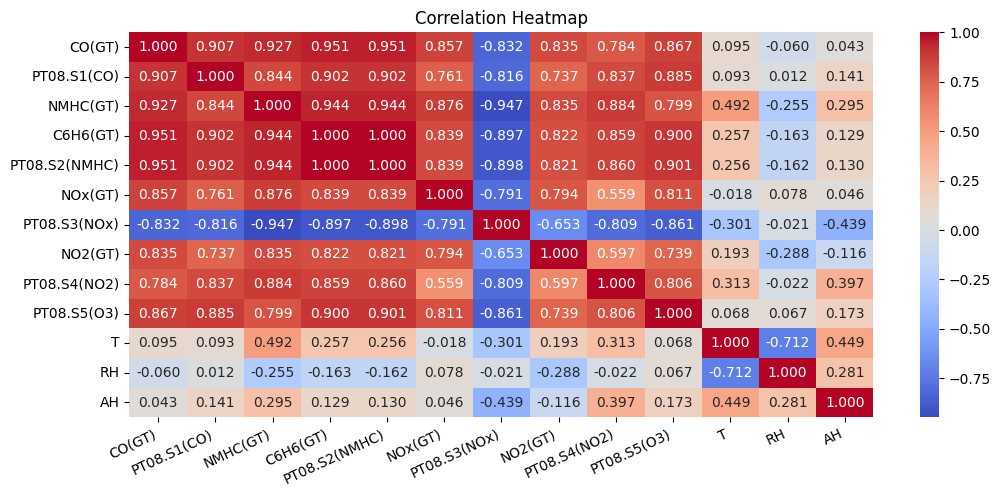

In [17]:
def show_correlation_heatmap(data, variables):
    plt.figure(figsize=(12, 5))
    plt.title("Correlation Heatmap")
    sns.heatmap(
        data.select(*variables).to_pandas().corr(), # pandas deals with missing data better than polars
        annot=True,
        cmap='coolwarm',
        fmt=".3f"
    )
    plt.xticks(rotation=25, ha='right')
    plt.show()

show_correlation_heatmap(normalised_training, raw_variables)

In [76]:
def check_outliers(normalised_data, raw_dataset, raw_variables):
    # Select only the normalized numeric variables to avoid datetime columns
    numeric_data = normalised_data.select(raw_variables)
    
    dataset_lengths = [
        len(raw_dataset.select(var).drop_nulls())
        for var in raw_variables
    ]
    sigma_percentages = [0.6827, 0.9545, 0.9973, 0.999937]
    
    # Compute outlier counts across all numeric variables (aggregated)
    # If you want per-variable counts, we can adjust this
    total_outliers = {i: 0 for i in range(1, 5)}
    for var in raw_variables:
        var_series = numeric_data.select(var).to_series()
        for i in range(1, 5):
            total_outliers[i] += (var_series.abs() > i).sum()  # Use Polars .abs() for safety
    
    sigma_counts = {
        i: [
            max(dataset_lengths) * (1 - percent),
            total_outliers[i],
            sum(dataset_lengths) * (1 - percent)
        ]
        for i, percent in enumerate(sigma_percentages, start=1)
    }
    
    return pl.DataFrame({
        "sigmas": [1, 2, 3, 4],
        "Expected min": [sigma_counts[i][0] for i in range(1, 5)],
        "Actual": [sigma_counts[i][1] for i in range(1, 5)],
        "Expected max": [sigma_counts[i][2] for i in range(1, 5)],
        "Lies within range": [all(b > a for a, b in it.pairwise(sigma_counts[i])) for i in range(1, 5)]
    })

check_outliers(full_normalised_data, raw_data, raw_variables)

shape: (4, 5)
┌────────┬──────────────┬────────┬──────────────┬───────────────────┐
│ sigmas ┆ Expected min ┆ Actual ┆ Expected max ┆ Lies within range │
│ ---    ┆ ---          ┆ ---    ┆ ---          ┆ ---               │
│ i64    ┆ f64          ┆ i64    ┆ f64          ┆ bool              │
╞════════╪══════════════╪════════╪══════════════╪═══════════════════╡
│ 1      ┆ 2852.8443    ┆ 41846  ┆ 33297.462    ┆ false             │
│ 2      ┆ 409.0905     ┆ 8914   ┆ 4774.77      ┆ false             │
│ 3      ┆ 24.2757      ┆ 1322   ┆ 283.338      ┆ false             │
│ 4      ┆ 0.566433     ┆ 143    ┆ 6.61122      ┆ false             │
└────────┴──────────────┴────────┴──────────────┴───────────────────┘

In [ ]:
def plot_original_vs_imputed(
    norm_data: pl.DataFrame,
    imputed_data: pl.DataFrame,
    variable: str,
    figsize: tuple = (15, 6)
) -> None:
    # Create a mask of originally missing values FROM RAW DATA
    originally_missing = norm_data.select(
        pl.col("linear_dt"),
        pl.col(variable).is_null().alias("was_missing")
    )

    # Join with imputed data and filter for originally missing values
    imputed_only = imputed_data.join(originally_missing, on="linear_dt").filter(
        pl.col("was_missing")
    ).select(
        "linear_dt",
        pl.col(variable)
    )

    # Combine original and imputed data with labels
    original_present = norm_data.select(
        pl.col("linear_dt"),
        pl.col(variable).alias("value")
    ).filter(pl.col("value").is_not_null()).with_columns(
        pl.lit("Original").alias("type")
    )

    imputed_only_labeled = imputed_only.select(
        pl.col("linear_dt"),
        pl.col(variable).alias("value")
    ).with_columns(
        pl.lit("Imputed").alias("type")
    )

    # Convert to pandas and plot
    combined = pl.concat([original_present, imputed_only_labeled]).to_pandas()

    print(f"{variable}:")
    print(f"  Original points: {len(original_present)}")
    print(f"  Imputed points: {len(imputed_only_labeled)}")

    plt.figure(figsize=figsize)
    for label, group in combined.groupby("type"):
        plt.scatter(group["linear_dt"], group["value"], label=label, alpha=0.6, s=10)
    plt.xlabel("linear_dt")
    plt.ylabel(variable)
    plt.title(f"Original vs Imputed values for {variable}")
    plt.legend()
    plt.show()

In [ ]:
class IterativeImputerNet(nn.Module):
    def __init__(
        self,
        n_impute_features: int,
        n_time_features: int,
        n_lags: int,
        hidden_sizes: Sequence[int] = (128, 64),
        know_whats_hidden: bool = False,
        lag_list: Sequence[int] | None = None,
        impute_var_names: Sequence[str] | None = None,
        time_var_names: Sequence[str] | None = None,
        layer_type: nn.Module = nn.GELU,
    ):
        super().__init__()
        # Persist hyperparameters so checkpoints can be reconstructed and inference can run standalone.
        self.n_impute_features = n_impute_features
        self.n_time_features = n_time_features
        self.n_lags = n_lags
        self.hidden_sizes = tuple(hidden_sizes)
        self.know_whats_hidden = know_whats_hidden
        self.lags = tuple(lag_list) if lag_list is not None else tuple(range(1, n_lags + 1))
        if len(self.lags) != n_lags:
            raise ValueError("len(lag_list) must equal n_lags when provided.")
        self.output_lags = (0,) + self.lags
        self.n_output_blocks = len(self.output_lags)
        self.impute_var_names = tuple(impute_var_names) if impute_var_names else None
        self.time_var_names = tuple(time_var_names) if time_var_names else None

        self.hidden_flag_width = n_impute_features if know_whats_hidden else 0
        self.value_block_width = n_impute_features + n_time_features
        self.feature_block_width = self.value_block_width + self.hidden_flag_width
        input_dim = self.feature_block_width * (1 + n_lags)
        output_dim = n_impute_features * self.n_output_blocks  # current + lagged targets

        self.block_slices = {
            lag: slice(idx * n_impute_features, (idx + 1) * n_impute_features)
            for idx, lag in enumerate(self.output_lags)
        }

        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            # layers.append(nn.BatchNorm1d(h))  # Add batch normalization
            if isinstance(layer_type, type):
                layers.append(layer_type())
            else:
                layers.append(layer_type)
            # layers.append(nn.Dropout(0.1))  # Add dropout for regularization
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

    def _build_feature_matrix(
        self,
        imputed_vals: np.ndarray,
        time_vals: np.ndarray,
        mask_vals: np.ndarray | None,
    ) -> np.ndarray:
        """Construct current + lagged feature blocks, mirroring the training layout."""
        n_rows = imputed_vals.shape[0]
        features = np.full((n_rows, self.feature_block_width * (1 + self.n_lags)), np.nan, dtype=np.float64)

        if time_vals.size:
            base_block = np.concatenate([imputed_vals, time_vals], axis=1)
        else:
            base_block = imputed_vals.copy()

        features[:, :self.value_block_width] = base_block

        base_hidden = None
        if self.know_whats_hidden:
            if mask_vals is None:
                raise ValueError("mask_vals is required when know_whats_hidden=True")
            base_hidden = 1.0 - mask_vals.astype(np.float64, copy=False)
            features[:, self.value_block_width:self.feature_block_width] = base_hidden

        for idx, lag in enumerate(self.lags, start=1):
            block_start = idx * self.feature_block_width
            value_dest = features[:, block_start:block_start + self.value_block_width]
            if lag < n_rows:
                value_dest[lag:] = base_block[:-lag]
            if self.know_whats_hidden:
                hidden_dest = features[:, block_start + self.value_block_width:block_start + self.feature_block_width]
                if lag < n_rows and base_hidden is not None:
                    hidden_dest[lag:] = base_hidden[:-lag]

        return features

    @staticmethod
    def _fill_from_prev(arr: np.ndarray, curr_row_idx) -> np.ndarray:
        """Use the previous row's value if the current value is NaN."""
        if np.isnan(arr[curr_row_idx - 1]).any():
            raise ValueError(f"Cannot fill row {curr_row_idx} because previous row contains NaN values.")
        mask = np.isnan(arr[curr_row_idx])
        arr[curr_row_idx][mask] = arr[curr_row_idx - 1][mask]
        return arr

    @torch.no_grad()
    def predict(
        self,
        history_values: np.ndarray,
        curr_row_idx: int,
        mutate: bool = True,
        clip_range: tuple[float, float] | None = None,
    ) -> np.ndarray:
        # Debugging checks
        if history_values.ndim != 2:
            raise ValueError("history_values must be a 2D array.")
        n_rows, n_cols = history_values.shape
        if n_rows == 0:
            raise ValueError("history_values must contain at least one row.")
        if n_cols < self.value_block_width:
            raise ValueError(
                "history_values must include at least n_impute_features + n_time_features columns."
            )
        if curr_row_idx < 0:
            raise IndexError("curr_row_idx must be non-negative.")
        if curr_row_idx > n_rows:
            raise IndexError("curr_row_idx exceeds the number of available rows.")
        
        target_idx = curr_row_idx - 1
        if target_idx < 0:
            raise IndexError("curr_row_idx must be at least 1 to expose row 0 for inference.")

        result_array = history_values if mutate else history_values.copy()
        impute_block = result_array[:, : self.n_impute_features]
        
        target_row_vals = impute_block[target_idx]
        missing_mask = np.isnan(target_row_vals)
        if not np.any(missing_mask):
            return result_array

        if self.n_time_features:
            time_block = result_array[:, self.n_impute_features : self.value_block_width]
        else:
            time_block = np.zeros((n_rows, 0), dtype=np.float64)

        upto_idx = target_idx + 1
        values_slice = np.array(impute_block[:upto_idx], dtype=np.float64, copy=False)
        time_slice = np.array(time_block[:upto_idx], dtype=np.float64, copy=False)
        
        values_ffill = self._fill_from_prev(values_slice, len(values_slice) - 1)
        
        mask_vals = None
        if self.know_whats_hidden:
            mask_vals = (~np.isnan(values_slice)).astype(np.float64)

        features = self._build_feature_matrix(
            values_ffill,
            time_slice,
            mask_vals,
        )

        feature_row = features[target_idx]
        # Fill any NaNs in feature_row with 0 to allow imputation, should not occur
        if np.isnan(feature_row).any():
            feature_row = np.nan_to_num(feature_row, nan=0.0)

        device = next(self.parameters()).device
        feature_tensor = torch.from_numpy(feature_row).double().unsqueeze(0).to(device)
        preds = self.net(feature_tensor).cpu().numpy()
        if clip_range is not None:
            preds = np.clip(preds, clip_range[0], clip_range[1])

        current_pred = preds[0, self.block_slices[0]]
        impute_block[target_idx, missing_mask] = current_pred[missing_mask]

        return result_array

    def save_to_disk(self, path: str) -> None:
        """Serialize model weights and configuration to disk."""
        checkpoint = {
            "state_dict": self.state_dict(),
            "config": {
                "n_impute_features": self.n_impute_features,
                "n_time_features": self.n_time_features,
                "n_lags": self.n_lags,
                "hidden_sizes": self.hidden_sizes,
                "know_whats_hidden": self.know_whats_hidden,
                "lag_list": self.lags,
                "impute_var_names": self.impute_var_names,
                "time_var_names": self.time_var_names,
            },
        }
        torch.save(checkpoint, path)

    @classmethod
    def load_from_disk(cls, path: str, map_location: str | torch.device | None = None) -> "IterativeImputerNet":
        """Load a checkpoint produced by save_to_disk."""
        checkpoint = torch.load(path, map_location=map_location)
        if "config" not in checkpoint or "state_dict" not in checkpoint:
            raise ValueError("Checkpoint missing required keys 'config' and 'state_dict'.")
        model = cls(**checkpoint["config"])
        model.load_state_dict(checkpoint["state_dict"])
        return model
    

def iterative_imputation(
    data: pl.DataFrame, 
    impute_vars: list[str],
    time_vars: list[str],
    lags: list[int] = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    epoch_count: int = 5,
    val_split_frac: float = 0.15,
    hidden_sizes: tuple[int, ...] = (128, 64, 32, 64, 128),
    starting_replication_scale: float = 1.0,
    starting_learning_rate: float = 1e-4,
    tikhonov_lambda: float = 0.0,
    output_clip_range: tuple | None = (-3, 3),
    lambda_mmd=1e-3,
    seed: int | None = 777,
    know_whats_hidden: bool = False,
    validation_skip_rate: int = 1,
    skip_val_for_first_n_epochs: int = 0,
    min_learning_rate: float = 1e-6,
    weight_decay: float = 0,
    layer_type: nn.Module = nn.GELU,
    noise_factor: float = 1.0,
    divergence_tolerance: float = 1.2,
    imputation_ema_alpha: float = 0.5,
    max_grad_norm: float = 1.0,
):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(True, warn_only=True)
        torch.backends.cudnn.allow_tf32 = False
        torch.backends.cudnn.benchmark = False
    
    lags = list(dict.fromkeys(lags))
    if tikhonov_lambda != 0 and (1 not in lags or 2 not in lags):
        raise ValueError("lags must include 1 and 2 so that lagged outputs can be trained.")
    if validation_skip_rate < 1:
        raise ValueError("validation_skip_rate must be >= 1")

    # Initial Imputation (Nearest same hour-of-week, interpolate, ffill/bfill)
    def impute_weekhour_linear_ffill_bfill(arr):
        arr = arr.copy()
        n_rows, n_cols = arr.shape

        # Compute weekday-hour averages (168 groups): group index = row_index % 168
        period = 24 * 7
        group_ids = np.arange(n_rows) % period

        # compute per-column, per-group means
        # means[g, c] = mean of arr[group_ids == g, c]
        means = np.full((period, n_cols), np.nan)

        for g in range(period):
            mask = (group_ids == g)
            if mask.any():
                means[g] = np.nanmean(arr[mask], axis=0)

        # Fill with weekday-hour averages
        for i in range(n_rows):
            g = group_ids[i]
            row = arr[i]
            missing = np.isnan(row)
            if missing.any():
                row[missing] = means[g, missing]

        # Linear interpolate over missing segments that have a known value on both sides
        for c in range(n_cols):
            col = arr[:, c]
            isnan = np.isnan(col)

            if not isnan.any():
                continue

            x = np.arange(n_rows)
            # Only interpolate where there are valid points at both ends
            valid = ~isnan
            if valid.sum() >= 2:
                col_interp = np.interp(x, x[valid], col[valid])
                # Assign only to segments where both sides exist.
                # But we must not overwrite cases that already have a known value.
                # np.interp already returns NaN-free values except where valid <2.
                missing = np.isnan(col)
                col[missing] = col_interp[missing]

            arr[:, c] = col

        # Forward fill
        for c in range(n_cols):
            col = arr[:, c]
            mask = np.isnan(col)
            if mask.any():
                # Forward fill: propagate the last known value
                last = np.nan
                for i in range(n_rows):
                    if not np.isnan(col[i]):
                        last = col[i]
                    else:
                        if not np.isnan(last):
                            col[i] = last
            arr[:, c] = col

        # Backfill
        for c in range(n_cols):
            col = arr[:, c]
            mask = np.isnan(col)
            if mask.any():
                last = np.nan
                for i in reversed(range(n_rows)):
                    if not np.isnan(col[i]):
                        last = col[i]
                    else:
                        if not np.isnan(last):
                            col[i] = last
            arr[:, c] = col

        return arr
    
    output_lags = [0] + lags
    n_output_blocks = len(output_lags)
    lag_to_block = {lag: idx for idx, lag in enumerate(output_lags)}
    
    # Data Splitting
    split_idx = int(len(data) * (1 - val_split_frac))
    train_data = data.slice(0, split_idx)
    val_data = data.slice(split_idx)

    # Initial Imputation
    train_impute_vals = train_data.select(impute_vars).to_numpy().astype(np.float64)
    train_imputed_vals = impute_weekhour_linear_ffill_bfill(train_impute_vals)
    train_imputed = train_data.with_columns([
        pl.Series(name=var, values=train_imputed_vals[:, i])
        for i, var in enumerate(impute_vars)
    ])

    # Keep train and validation separate
    train_imputed_vals_np = train_imputed.select(impute_vars).to_numpy().astype(np.float64)
    validation_imputations_np = val_data.select(impute_vars).to_numpy().astype(np.float64)
    
    # check if there are any NaNs left in train_imputed_vals_np
    if np.isnan(train_imputed_vals_np).any():
        raise ValueError("NaN values remain in train_imputed_vals_np after initial imputation.")

    # Combine for initial setup
    imputed_vals_np = np.vstack([train_imputed_vals_np, validation_imputations_np])
    
    # Time values for the full dataset
    train_time_vals_np = (
        train_imputed.select(time_vars).to_numpy().astype(np.float64)
        if time_vars
        else np.zeros((len(train_imputed), 0), dtype=np.float64)
    )
    val_time_vals_np = (
        val_data.select(time_vars).to_numpy().astype(np.float64)
        if time_vars
        else np.zeros((len(val_data), 0), dtype=np.float64)
    )
    time_vals_np = np.vstack([train_time_vals_np, val_time_vals_np])
    
    # Create Masks and Lagged Truth Values
    def build_lag_block(values: np.ndarray, lag: int) -> np.ndarray:
        block = np.full_like(values, np.nan, dtype=np.float64)
        if lag == 0:
            block[:] = values
        elif lag < len(values):
            block[lag:] = values[:-lag]
        return block

    original_values_np = data.select(impute_vars).to_numpy().astype(np.float64)
    original_values_by_lag = {lag: build_lag_block(original_values_np, lag) for lag in output_lags}
    mask_by_lag = {
        lag: np.where(np.isnan(values), 0.0, 1.0).astype(np.float64)
        for lag, values in original_values_by_lag.items()
    }
    original_values = original_values_by_lag[0]
    full_mask = mask_by_lag[0]
    train_mask_by_lag = {lag: mask[:split_idx] for lag, mask in mask_by_lag.items()}
    val_mask_by_lag = {lag: mask[split_idx:] for lag, mask in mask_by_lag.items()}
    train_mask = train_mask_by_lag[0]
    val_mask = val_mask_by_lag[0]

    def assign_holdout_columns(val_mask: np.ndarray) -> np.ndarray:
        n_rows, n_cols = val_mask.shape
        assignments = np.full(n_rows, -1, dtype=np.int64)
        col_counts = np.zeros(n_cols, dtype=np.int64)
        for row_idx in range(n_rows):
            known_cols = np.where(val_mask[row_idx] == 1.0)[0]
            if known_cols.size == 0:
                continue
            counts_subset = col_counts[known_cols]
            min_count = counts_subset.min()
            candidate_cols = known_cols[counts_subset == min_count]
            chosen = int(candidate_cols[0])
            assignments[row_idx] = chosen
            col_counts[chosen] += 1
        return assignments

    val_holdout_cols = assign_holdout_columns(val_mask)

    # Precompute validation base with holdouts set to NaN
    validation_base = val_data.select(impute_vars).to_numpy().astype(np.float64)
    for i in range(len(validation_base)):
        col = val_holdout_cols[i]
        if 0 <= col < len(impute_vars):
            validation_base[i, col] = np.nan

    n_impute_features = len(impute_vars)
    n_time_features = len(time_vars)
    value_block_width = n_impute_features + n_time_features
    hidden_flag_width = n_impute_features if know_whats_hidden else 0
    feature_block_width = value_block_width + hidden_flag_width

    # Prepare for Iterative Refinement.
    def mmd_rbf(x: torch.Tensor, y: torch.Tensor, sigma: float = 1.0) -> torch.Tensor:
        # This fn was only used during model search, but is retained for completeness.
        if x.numel() == 0 or y.numel() == 0:
            return torch.zeros((), device=x.device if x.numel() > 0 else y.device)

        x = x.view(-1, 1)
        y = y.view(-1, 1)

        XX = (x - x.t()) ** 2
        YY = (y - y.t()) ** 2
        XY = (x - y.t()) ** 2

        k_xx = torch.exp(-XX / (2 * sigma ** 2))
        k_yy = torch.exp(-YY / (2 * sigma ** 2))
        k_xy = torch.exp(-XY / (2 * sigma ** 2))

        mmd2 = k_xx.mean() + k_yy.mean() - 2.0 * k_xy.mean()
        return mmd2

    # lags can't be precomputed since the data is changing
    def create_lagged_features(
        imputed_vals: np.ndarray,
        time_vals: np.ndarray,
        mask_vals: np.ndarray | None,
    ) -> np.ndarray:
        n_rows = imputed_vals.shape[0]
        feature_dim = feature_block_width * (1 + len(lags))
        features = np.full((n_rows, feature_dim), np.nan, dtype=np.float64)
        features[:, :n_impute_features] = imputed_vals
        if n_time_features:
            features[:, n_impute_features:value_block_width] = time_vals

        base_hidden = None
        if know_whats_hidden:
            if mask_vals is None:
                raise ValueError("mask_vals is required when know_whats_hidden=True")
            mask_float = mask_vals.astype(np.float64, copy=False)
            base_hidden = 1.0 - mask_float
            features[:, value_block_width:feature_block_width] = base_hidden

        for idx, lag in enumerate(lags, start=1):
            block_start = idx * feature_block_width
            value_dest = features[:, block_start:block_start + value_block_width]
            if lag < n_rows:
                value_dest[lag:, :n_impute_features] = imputed_vals[:-lag]
                if n_time_features:
                    value_dest[lag:, n_impute_features:value_block_width] = time_vals[:-lag]
            if know_whats_hidden:
                hidden_dest = features[:, block_start + value_block_width:block_start + feature_block_width]
                if lag < n_rows and base_hidden is not None:
                    hidden_dest[lag:] = base_hidden[:-lag]

        return features

    def sequential_validation_pass(
        model: "IterativeImputerNet",
        full_imputed_vals: np.ndarray,
        full_time_vals: np.ndarray,
        original_vals_full: np.ndarray,
        holdout_cols: np.ndarray,
        split_idx: int,
        full_mask_arr: np.ndarray,
        output_clip_range: tuple[float, float] | None,
    ) -> tuple[np.ndarray, float]:
        n_rows_total = full_imputed_vals.shape[0]
        if split_idx >= n_rows_total:
            return full_imputed_vals[:, :model.n_impute_features].copy(), 0.0

        n_impute_features = model.n_impute_features
        value_block_width = model.value_block_width

        # Overwrite validation section with base (holdouts as NaN)
        full_imputed_vals[split_idx:, :n_impute_features] = validation_base
        # Time values remain unchanged

        # Create history matrix view
        history_matrix = np.column_stack([full_imputed_vals, full_time_vals]) if model.n_time_features > 0 else full_imputed_vals

        imputed_section = full_imputed_vals[:, :n_impute_features]

        val_mask = full_mask_arr[split_idx:]
        n_val_rows, _ = val_mask.shape
        holdout_cols = holdout_cols.astype(np.int64, copy=False)

        known_counts = val_mask.sum(axis=0).astype(np.float64)
        valid_cols = known_counts > 0
        if not np.any(valid_cols):
            return imputed_section, 0.0

        missing_fractions = 1.0 - (known_counts / (float(n_val_rows) + 1e-8))
        missing_fractions = np.maximum(missing_fractions, 1e-8)
        col_weights = np.ones(len(valid_cols)) / len(valid_cols)

        col_sq_errors = np.zeros(n_impute_features, dtype=np.float64)
        col_counts = np.zeros(n_impute_features, dtype=np.int64)

        for val_row_idx in range(n_val_rows):
            global_idx = split_idx + val_row_idx
            
            hold_col = holdout_cols[val_row_idx] if val_row_idx < len(holdout_cols) else -1
            
            can_hold = (
                0 <= hold_col < n_impute_features and 
                valid_cols[hold_col] and 
                full_mask_arr[global_idx, hold_col] == 1.0
            )

            original_val = np.nan
            if can_hold:
                original_val = original_vals_full[global_idx, hold_col]
                # Holdout is already NaN in validation_base, no need to set again

            # Impute the row. `predict` will handle whether there's anything to do.
            # experimented with allowing multiple passes per row
            # for _ in range(20):
            model.predict(
                history_matrix,
                curr_row_idx=global_idx + 1,
                mutate=True,
                clip_range=None,
            )

            if can_hold:
                pred_val = imputed_section[global_idx, hold_col]
                if not np.isnan(pred_val) and not np.isnan(original_val):
                    col_sq_errors[hold_col] += float((pred_val - original_val) ** 2)
                    col_counts[hold_col] += 1
                # No restoration needed, as we're returning the imputed version

        valid_indices = np.where(valid_cols)[0]
        mse_terms = []
        weight_terms = []
        for weight_idx, col_idx in enumerate(valid_indices):
            if col_counts[col_idx] == 0:
                continue
            mse_terms.append(float(col_sq_errors[col_idx]) / float(col_counts[col_idx]))
            weight_terms.append(col_weights[weight_idx])

        if not mse_terms:
            val_loss = 0.0
        else:
            weights_arr = np.array(weight_terms, dtype=np.float64)
            weights_arr = weights_arr / weights_arr.sum()
            mse_arr = np.array(mse_terms, dtype=np.float64)
            val_loss = float((mse_arr * weights_arr).sum())

        return imputed_section, val_loss

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    block_slices = {
        lag: slice(idx * n_impute_features, (idx + 1) * n_impute_features)
        for idx, lag in enumerate(output_lags)
    }
    model = IterativeImputerNet(
        n_impute_features,
        n_time_features,
        len(lags),
        hidden_sizes,
        know_whats_hidden=know_whats_hidden,
        lag_list=lags,
        impute_var_names=impute_vars,
        time_var_names=time_vars,
    ).double().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=starting_learning_rate, weight_decay=weight_decay)
    
    plotlosses = PlotLosses()
    train_losses, val_losses_plotted, val_losses_unclipped = [], [], []
    best_val_loss = float('inf')
    best_train_loss = float('inf')
    best_model_state = None
    best_imputed_data = None
    last_recorded_val_loss: float | None = None
    
    # Adaptive parameters
    current_replication_scale = starting_replication_scale
    current_learning_rate = starting_learning_rate
    
    # Snapshot for Revert-to-Best
    best_imputed_vals_np = imputed_vals_np.copy()
    
    iteration = 0

    last_learning_rate_increase = 0
    learning_rate_net_decreases = 0
    
    # Store of hard examples: stores tuples of (loss, index, mask, noise_values)
    hard_examples = []
    
    while iteration <= epoch_count:
        # during development, an adjustable learning rate was used,
        # but it was ultimately rendered useless by other improvements.
        # keeping the code for reference.

        # if last_learning_rate_increase < 3:
        #     last_learning_rate_increase += 1
        # else:
        #     current_training_loss = train_losses[-1]
        #     current_val_loss = val_losses_unclipped[-1]
        #     bad_loss_behaviour = (
        #         current_training_loss >= max(train_losses[-3:-1])
        #     )
        #     good_loss_behaviour = (
        #         current_training_loss >= min(train_losses[-50:-1])
        #     )
        #     if bad_loss_behaviour:
        #         # Validation loss got worse - reduce learning rate
        #         if current_learning_rate >= min_learning_rate * 1.5:
        #             current_learning_rate /= 1.5
        #         # Update optimizer learning rate
        #         for param_group in optimizer.param_groups:
        #             param_group['lr'] = current_learning_rate
        #         last_learning_rate_increase = 0
        #         learning_rate_net_decreases += 1
        #     elif good_loss_behaviour:
        #         current_learning_rate *= 1.224745
        #         # Update optimizer learning rate
        #         for param_group in optimizer.param_groups:
        #             param_group['lr'] = current_learning_rate
        #         learning_rate_net_decreases -= 1
        #         last_learning_rate_increase += 1
        
        # Training Phase:
        lagged_features_full = create_lagged_features(
            imputed_vals_np,
            time_vals_np,
            full_mask,
        )
        X_train_full = lagged_features_full[:split_idx]
        valid_idx_train = ~np.isnan(X_train_full).any(axis=1)
        X_train = X_train_full[valid_idx_train]

        lag_target_cache = {lag: build_lag_block(imputed_vals_np, lag) for lag in output_lags}
        y_train_blocks_full = {lag: lag_target_cache[lag][:split_idx] for lag in output_lags}
        y_train_blocks = [y_train_blocks_full[lag][valid_idx_train] for lag in output_lags]
        mask_train_blocks = [train_mask_by_lag[lag][valid_idx_train] for lag in output_lags]

        y_train = np.concatenate(y_train_blocks, axis=1)
        mask_train_combined = np.concatenate(mask_train_blocks, axis=1)

        y_train_current = y_train_blocks[0]
        mask_train_current = mask_train_blocks[0]

        X_tensor = torch.from_numpy(X_train).double().to(device)
        y_tensor = torch.from_numpy(y_train).double().to(device)
        mask_tensor_current = torch.from_numpy(mask_train_current).double().to(device)
        mask_tensor_all = torch.from_numpy(mask_train_combined).double().to(device)

        n_samples = len(X_tensor)

        present_counts = np.sum(mask_train_current, axis=0)
        present_fractions = present_counts / (n_samples + 1e-8)
        missing_fractions = 1.0 - present_fractions
        smooth_penalties = missing_fractions + 1e-8
        smooth_penalties /= smooth_penalties.mean()
        smooth_penalties_t = torch.from_numpy(smooth_penalties.astype(np.float64)).to(device)

        # Sample hiding mask for all columns at once (based on original missingness patterns)
        full_mask_t = torch.from_numpy(full_mask).to(device=device, dtype=torch.float64)
        original_known_patterns = full_mask_t[:, :n_impute_features]
        sampled_idx = torch.randint(0, original_known_patterns.shape[0], (n_samples,), device=device)
        sampled_known_patterns = original_known_patterns[sampled_idx]
        sampled_missing_patterns = 1.0 - sampled_known_patterns
        hide_mask = (sampled_missing_patterns == 1.0) & (mask_tensor_current == 1.0)

        # Randomly mask one additional known feature per row
        # extra_hide_col = torch.randint(0, n_impute_features, (n_samples, 1), device=device)
        # extra_hide_mask = torch.zeros_like(hide_mask).scatter_(1, extra_hide_col, True)
        # hide_mask = hide_mask | (extra_hide_mask & (mask_tensor_current == 1.0))

        # Instead of masking one additional known feature, swap two pairs of random positions in hide_mask
        pair1_cols = torch.randint(0, n_impute_features, (n_samples, 2), device=device)
        pair2_cols = torch.randint(0, n_impute_features, (n_samples, 2), device=device)

        # Swap the first pair
        val1 = hide_mask.gather(1, pair1_cols[:, 0].unsqueeze(1)).squeeze(1)
        val2 = hide_mask.gather(1, pair1_cols[:, 1].unsqueeze(1)).squeeze(1)
        hide_mask.scatter_(1, pair1_cols[:, 0].unsqueeze(1), val2.unsqueeze(1))
        hide_mask.scatter_(1, pair1_cols[:, 1].unsqueeze(1), val1.unsqueeze(1))

        # Swap the second pair
        val1 = hide_mask.gather(1, pair2_cols[:, 0].unsqueeze(1)).squeeze(1)
        val2 = hide_mask.gather(1, pair2_cols[:, 1].unsqueeze(1)).squeeze(1)
        hide_mask.scatter_(1, pair2_cols[:, 0].unsqueeze(1), val2.unsqueeze(1))
        hide_mask.scatter_(1, pair2_cols[:, 1].unsqueeze(1), val1.unsqueeze(1))

        # Corrupt the inputs at once
        corrupted_X = X_tensor.clone()
        # Use Lag 1 values as "noise" (replacement values) for Forward Fill corruption
        noise = X_tensor[:, block_slices[1]]
        corrupted_X[:, :n_impute_features] = torch.where(hide_mask, noise, corrupted_X[:, :n_impute_features])

        # Update hidden indicators if applicable
        if know_whats_hidden:
            hidden_start = value_block_width
            hidden_end = value_block_width + n_impute_features
            corrupted_X[:, hidden_start:hidden_end] = torch.where(hide_mask, 1.0, corrupted_X[:, hidden_start:hidden_end])

        # Hard Example Mining for Replay
        replay_indices_list = []
        replay_masks_list = []
        
        if len(hard_examples) > 0:
            # Unzip the queue
            # Entry: (loss, index, mask) - mask is derived from Lag 1
            for _, idx, m in hard_examples:
                replay_indices_list.append(idx)
                replay_masks_list.append(m)
            
            replay_indices = torch.tensor(replay_indices_list, device=device, dtype=torch.long)
            replay_masks = torch.stack(replay_masks_list).to(device)
            
            # Get current values for these indices
            # X_tensor is the full training batch for this iteration
            X_replay = X_tensor[replay_indices].clone()
            
            # Apply stored corruption (using current Lag 1 values as fill)
            X_replay_impute = X_replay[:, :n_impute_features]
            # Use Lag 1 values as mask
            replay_noise = X_replay[:, block_slices[1]]
            X_replay_impute = torch.where(replay_masks, replay_noise, X_replay_impute)
            X_replay[:, :n_impute_features] = X_replay_impute
            
            # Update hidden indicators if applicable
            if know_whats_hidden:
                 hidden_start = value_block_width
                 hidden_end = value_block_width + n_impute_features
                 X_replay[:, hidden_start:hidden_end] = torch.where(replay_masks, 1.0, X_replay[:, hidden_start:hidden_end])

            # Combine with main batch
            final_X = torch.cat([corrupted_X, X_replay], dim=0)
            
            # We also need targets and masks for loss calculation
            y_replay = y_tensor[replay_indices]
            mask_all_replay = mask_tensor_all[replay_indices]
            
            final_y = torch.cat([y_tensor, y_replay], dim=0)
            final_mask_all = torch.cat([mask_tensor_all, mask_all_replay], dim=0)
            
        else:
            final_X = corrupted_X
            final_y = y_tensor
            final_mask_all = mask_tensor_all

        # Slicing Loop
        mask_tensor_by_lag = {}
        y_tensor_by_lag = {}
        offset = 0
        for lag in output_lags:
            mask_tensor_by_lag[lag] = final_mask_all[:, offset:offset + n_impute_features]
            y_tensor_by_lag[lag] = final_y[:, offset:offset + n_impute_features]
            offset += n_impute_features
            
        final_mask_current = mask_tensor_by_lag[0]

        # Single forward pass
        preds = model(final_X)

        # Compute loss for current (non-lagged) outputs
        current_preds = preds[:, block_slices[0]]
        current_targets = final_y[:, :n_impute_features]
        squared_errors = (current_preds - current_targets) ** 2
        masked_errors = squared_errors * final_mask_current
        
        # Per-sample loss for queue update
        per_sample_loss = masked_errors.sum(dim=1)
        
        total_loss = masked_errors.sum()

        # Add auxiliary losses for lagged outputs
        aux_losses = []
        for lag in output_lags[1:]:
            mask_tensor_lag = mask_tensor_by_lag[lag]
            lag_known = mask_tensor_lag.sum().item()
            if lag_known == 0:
                continue
            lag_preds = preds[:, block_slices[lag]]
            lag_targets = y_tensor_by_lag[lag]
            lag_errors = (lag_preds - lag_targets) ** 2
            lag_loss = (lag_errors * mask_tensor_lag).sum()
            total_loss += lag_loss
            aux_losses.append(lag_loss)

        # Add Tikhonov smoothness penalty to offset bad results from distribution shift
        if tikhonov_lambda > 0:
            current_pred = preds[:n_samples, block_slices[0]]
            lag1_pred = preds[:n_samples, block_slices[1]]
            lag2_pred = preds[:n_samples, block_slices[2]]
            second_diff = current_pred - 2 * lag1_pred + lag2_pred
            smooth_errors = second_diff ** 2
            if smooth_penalties_t.numel() > 0:
                weighted_smooth = smooth_errors * smooth_penalties_t.unsqueeze(0)
                smooth_loss = tikhonov_lambda * weighted_smooth.sum()
                total_loss += smooth_loss
                aux_losses.append(smooth_loss)

        # Add MMD penalty for distribution shift
        if lambda_mmd > 0:
            train_mask_full = torch.from_numpy(full_mask[:split_idx]).to(device=device, dtype=torch.float64)
            original_train_full = torch.from_numpy(original_values[:split_idx]).to(device=device, dtype=torch.float64)
            valid_idx_train_t = torch.from_numpy(valid_idx_train).to(device=device, dtype=torch.bool)
            train_mask_used = train_mask_full[valid_idx_train_t]
            original_train_used = original_train_full[valid_idx_train_t]

            mmd_terms = []
            for j in range(n_impute_features):
                obs_mask_j = train_mask_used[:, j] == 1.0
                if not obs_mask_j.any():
                    continue
                x_obs_j = original_train_used[obs_mask_j, j]
                miss_mask_j = train_mask_used[:, j] == 0.0
                if not miss_mask_j.any():
                    continue
                x_imp_j = current_preds[:n_samples][miss_mask_j, j]
                mmd_j = mmd_rbf(x_obs_j, x_imp_j, sigma=1.0)
                if torch.isfinite(mmd_j):
                    mmd_terms.append(mmd_j)
            if mmd_terms:
                mmd_loss = lambda_mmd * torch.stack(mmd_terms).mean()
                total_loss += mmd_loss
                aux_losses.append(mmd_loss)

        # Backward pass and optimizer step (gradient from whole training set at once)
        total_loss.backward()
        if max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()
        
        # Update Hard Examples
        with torch.no_grad():            
            new_candidates = []
            
            # 1. From Original Batch
            # Needed to move to CPU
            curr_losses = per_sample_loss[:n_samples].cpu().tolist()
            curr_masks = hide_mask.cpu()
            
            for i in range(n_samples):
                new_candidates.append((
                    curr_losses[i],
                    i, # Index into X_train
                    curr_masks[i], # 1D mask
                ))
                
            # 2. From Replay Batch
            if len(hard_examples) > 0:
                replay_losses = per_sample_loss[n_samples:].cpu().tolist()
                # Replay indices/masks are already available
                # replay_indices is tensor on device
                r_indices = replay_indices.cpu().tolist()
                r_masks = replay_masks.cpu()
                
                for i in range(len(hard_examples)):
                    new_candidates.append((
                        replay_losses[i],
                        r_indices[i],
                        r_masks[i],
                    ))
            
            # Sort by loss descending and keed the hardest
            new_candidates.sort(key=lambda x: x[0], reverse=True)
            hard_examples = new_candidates[:15_000]

        # Compute average loss for logging
        total_known_count = mask_tensor_current.sum().item()
        avg_loss = total_loss.item() / total_known_count if total_known_count > 0 else 0.0

        train_losses.append(avg_loss)
        model.eval()
        with torch.no_grad():
            # Create features for the training dataset only
            X_train_for_update = lagged_features_full[:split_idx]
            valid_for_pred = ~np.isnan(X_train_for_update).any(axis=1)
            
            if valid_for_pred.any():
                X_pred = X_train_for_update[valid_for_pred]
                X_pred_tensor = torch.from_numpy(X_pred).double().to(device)
                
                predictions = model(X_pred_tensor).cpu().numpy()
                if output_clip_range is not None:
                    clip_min, clip_max = output_clip_range
                    predictions = np.clip(predictions, clip_min, clip_max)
                pred_current = predictions[:, block_slices[0]]

                # Update only the training portion of imputed_vals_np
                train_indices = np.where(valid_for_pred)[0]
                for i, idx in enumerate(train_indices):
                    for col in range(n_impute_features):
                        if full_mask[idx, col] == 0:  # Only update missing values
                            # EMA Update
                            old_val = imputed_vals_np[idx, col]
                            new_val = pred_current[i, col]
                            imputed_vals_np[idx, col] = (1 - imputation_ema_alpha) * old_val + imputation_ema_alpha * new_val
                
                if output_clip_range is not None:
                    clip_min, clip_max = output_clip_range
                    train_missing_mask = (full_mask[:split_idx] == 0)
                    imputed_vals_np[:split_idx][train_missing_mask] = np.clip(
                        imputed_vals_np[:split_idx][train_missing_mask], clip_min, clip_max
                    )

        # Validation Phase
        run_every_n = ((iteration + 1) % validation_skip_rate == 0)
        force_first = (iteration == 0)
        force_last = (iteration + 1 == epoch_count)
        should_run_validation = force_first or (run_every_n and iteration >= skip_val_for_first_n_epochs) or force_last
        ran_validation = False
        validation_snapshot_np: np.ndarray | None = None
        if should_run_validation:
            # Reset validation section to original values before validation
            imputed_vals_np[split_idx:] = original_values[split_idx:]
            sequential_vals_np, val_loss_calc = sequential_validation_pass(
                model,
                imputed_vals_np,
                time_vals_np,
                original_values,
                val_holdout_cols,
                split_idx,
                full_mask,
                output_clip_range,
            )
            val_loss_value = float(val_loss_calc)
            last_recorded_val_loss = val_loss_value
            ran_validation = True
            validation_snapshot_np = sequential_vals_np
        else:
            if last_recorded_val_loss is None:
                val_loss_value = float(avg_loss)
            else:
                val_loss_value = last_recorded_val_loss

        val_losses_plotted.append(min(val_loss_value, 50.0))
        val_losses_unclipped.append(val_loss_value)
        
        # Log losses and update plot
        logs = {
            'log_loss': np.log(avg_loss + 1e-8),
            'validation_log_loss': np.log(float(val_loss_value) + 1e-8),
        }
        plotlosses.update(logs)
        plotlosses.send()
        print()
        print(f"Iteration: {iteration + 1}/{epoch_count}")
        print(f"Loss (Best): {float(best_val_loss):.8f}")
        print(f"Loss (Curr): {float(val_loss_value):.8f}")
        if not ran_validation:
            print(f"Validation skipped (validation_skip_rate={validation_skip_rate}); last recorded value reused.")
        print(f"Learning rate: {current_learning_rate:.2e}")
        print(f"Replication scale: {current_replication_scale:.1f}")

        # Check for Best Model & Revert Logic
        if ran_validation:
            if val_loss_value < best_val_loss:
                best_val_loss = float(val_loss_value)
                best_model_state = model.state_dict()
                # Save best imputed data snapshot
                best_imputed_vals_np = imputed_vals_np.copy()
                
                # Only concatenate when saving the best model
                if validation_snapshot_np is not None:
                    combined_vals_np = validation_snapshot_np
                else:
                    combined_vals_np = imputed_vals_np
                
                # Create DataFrame from numpy arrays
                imputed_data_temp = pl.concat([train_imputed, val_data], how="vertical_relaxed")
                replacement_series = [
                    pl.Series(name=var, values=combined_vals_np[:, idx])
                    for idx, var in enumerate(impute_vars)
                ]
                best_imputed_data = imputed_data_temp.with_columns(replacement_series)
            
        # Check for divergence
        # if val_loss_value > best_val_loss * divergence_tolerance and iteration > 5:
        if avg_loss > best_train_loss * divergence_tolerance and iteration > 5:
            print(f"Divergence detected (Training Loss {avg_loss:.4f} > {divergence_tolerance} * Best {best_train_loss:.4f}). Reverting to best imputed data.")
            imputed_vals_np[:] = best_imputed_vals_np[:]
        if avg_loss < best_train_loss:
            best_train_loss = float(avg_loss)
        
        iteration += 1

        # Prompt to add more iterations:
        if iteration == epoch_count:
            try:
                response = input(f"\nCompleted {epoch_count} iterations. Add more? (Enter a number, or anything else to exit): ")
                additional_iterations = int(response)
                if additional_iterations > 0:
                    epoch_count += additional_iterations
                    print(f"Continuing training for {additional_iterations} more iterations...")
            except ValueError:
                # If input is not a number, exit the loop
                print("Exiting training.")

    # Return Best Model and Results
    best_model = IterativeImputerNet(
        n_impute_features,
        n_time_features,
        len(lags),
        hidden_sizes,
        know_whats_hidden=know_whats_hidden,
        lag_list=lags,
        impute_var_names=impute_vars,
        time_var_names=time_vars,
    )
    if best_model_state:
        best_model.load_state_dict(best_model_state)
    
    return best_imputed_data, best_model, train_losses, val_losses_unclipped

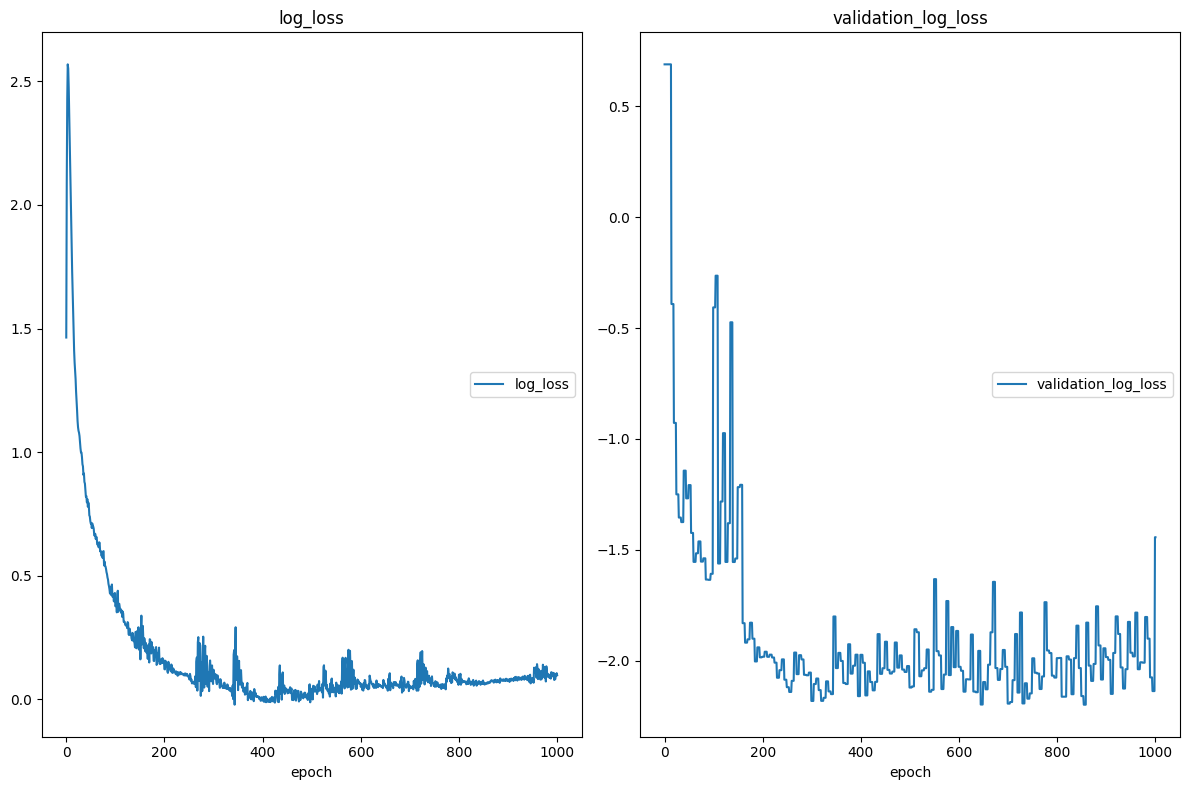

log_loss
	log_loss         	 (min:   -0.021, max:    2.569, cur:    0.098)
validation_log_loss
	validation_log_loss 	 (min:   -2.199, max:    0.690, cur:   -1.443)

Iteration: 1001/1000
Loss (Best): 0.11091880
Loss (Curr): 0.23613076
Validation skipped (validation_skip_rate=5); last recorded value reused.
Learning rate: 2.00e-02
Replication scale: 1.0
Divergence detected (Training Loss 1.1029 > 1 * Best 0.9788). Reverting to best imputed data.


In [20]:
imputed_df, best_model, train_loss, val_loss = iterative_imputation(
    normalised_training_and_validation,
    impute_vars=raw_variables,
    time_vars=[],
    epoch_count=1000,
    val_split_frac=0.15,
    hidden_sizes=(13,12,),
    lags=[1, 2, 3],
    starting_learning_rate=2e-2,
    output_clip_range=(-3.3, 3.3),
    tikhonov_lambda=0,
    lambda_mmd=0,
    seed=777,
    validation_skip_rate=5,
    know_whats_hidden=False,
    skip_val_for_first_n_epochs=10,
    layer_type=nn.GELU,
    divergence_tolerance=1,
    imputation_ema_alpha=0.1,
    max_grad_norm=1.0,
)
# LOOKS FANTASTIC! Model A1

In [23]:
time_vars = list(normalised_test.schema)[:15]
time_vars

['linear_dt',
 'sin_time_of_year',
 'cos_time_of_year',
 'is_mon',
 'is_tue',
 'is_wed',
 'is_thu',
 'is_fri',
 'is_sat',
 'is_sun',
 'is_weekday',
 'sin_time_of_week',
 'cos_time_of_week',
 'sin_hour_of_day',
 'cos_hour_of_day']

In [24]:
# best_model.save_to_disk("exp.pth")
model2 = best_model
model2.double()
model2.eval()
starting_index = 4  # for lags [0,1,2,3]
reimputed_data = (
    imputed_df.slice(0, starting_index)
    .vstack(
        # normalised_training_and_validation.slice(starting_index)
        normalised_data.slice(starting_index)
    ).select(raw_variables)
).to_numpy().astype(np.float64)
for i in range(starting_index, len(normalised_data)):
    model2.predict(reimputed_data, i + 1, mutate=True)

reimputed_data = normalised_data.select(time_vars).hstack(
    pl.DataFrame(reimputed_data, schema=[var for var in imputed_df.schema if var in raw_variables])
)

In [25]:
best_model.save_to_disk("Model A1.pth")
reimputed_data.write_ipc("Model A1 full imputed dataset.parquet")
pl.DataFrame(train_loss).write_ipc("Model A1 training loss.parquet")
pl.DataFrame(val_loss).write_ipc("Model A1 validation loss.parquet")

In [26]:
nan_mask = np.isnan(reimputed_data.to_numpy())
print(f"Rows with NaNs: {np.where(nan_mask.any(axis=1))[0]}")
print(f"Columns with NaNs: {np.where(nan_mask.any(axis=0))[0]}")

Rows with NaNs: []
Columns with NaNs: []


CO(GT):
  Original points: 5526
  Imputed points: 1584


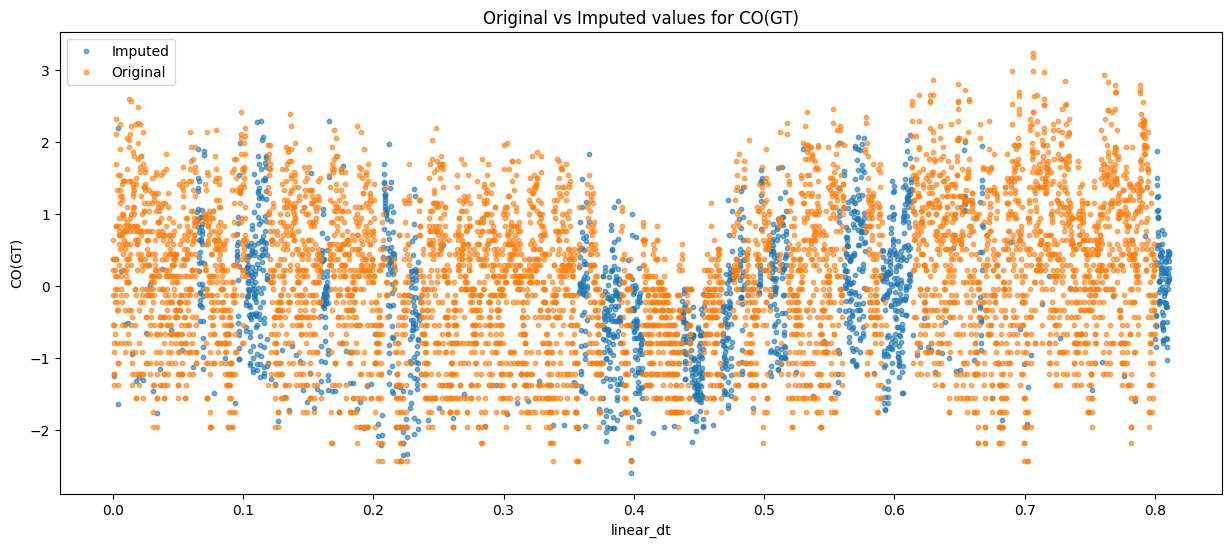

PT08.S1(CO):
  Original points: 6882
  Imputed points: 228


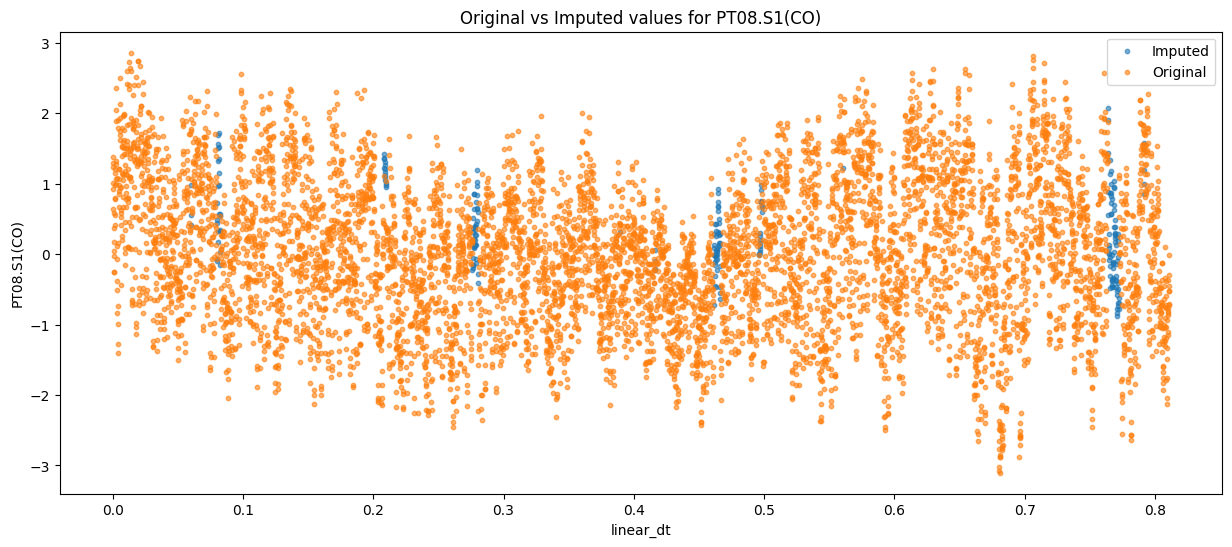

NMHC(GT):
  Original points: 914
  Imputed points: 6196


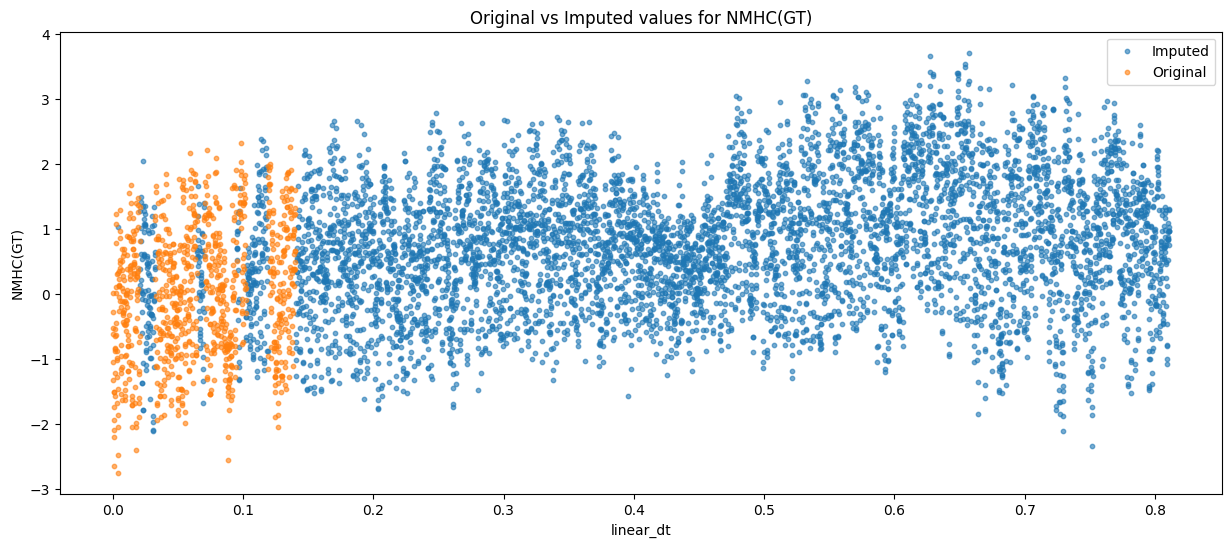

C6H6(GT):
  Original points: 6882
  Imputed points: 228


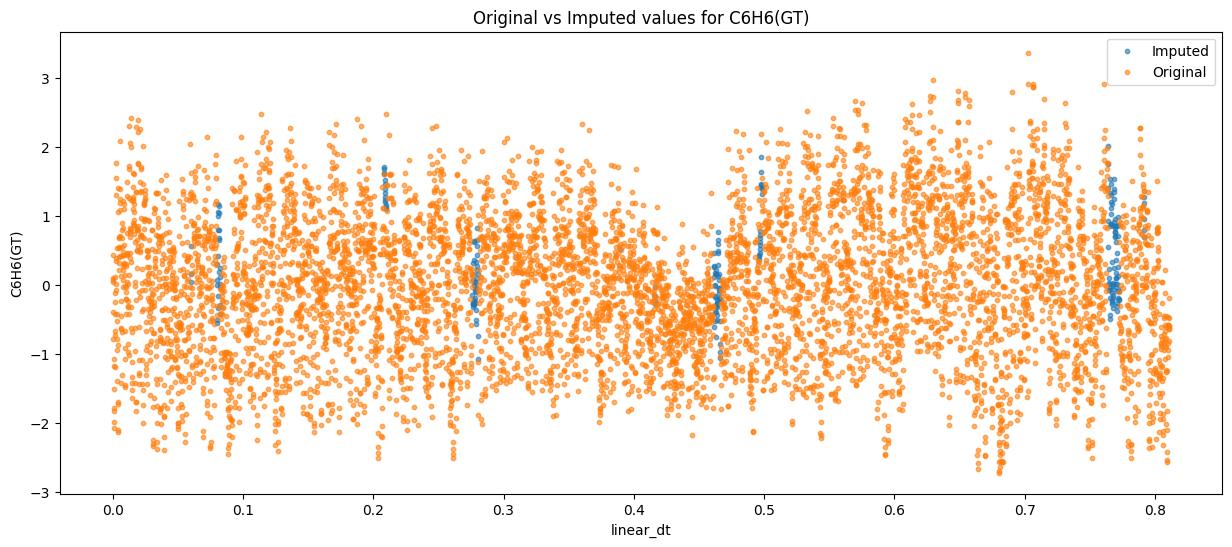

PT08.S2(NMHC):
  Original points: 6882
  Imputed points: 228


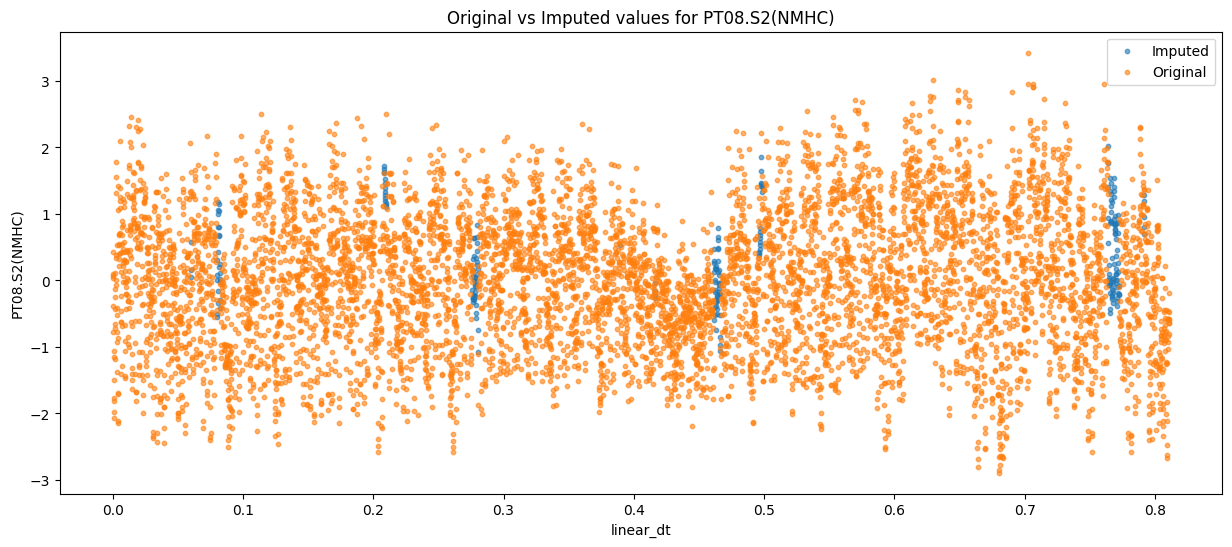

NOx(GT):
  Original points: 5546
  Imputed points: 1564


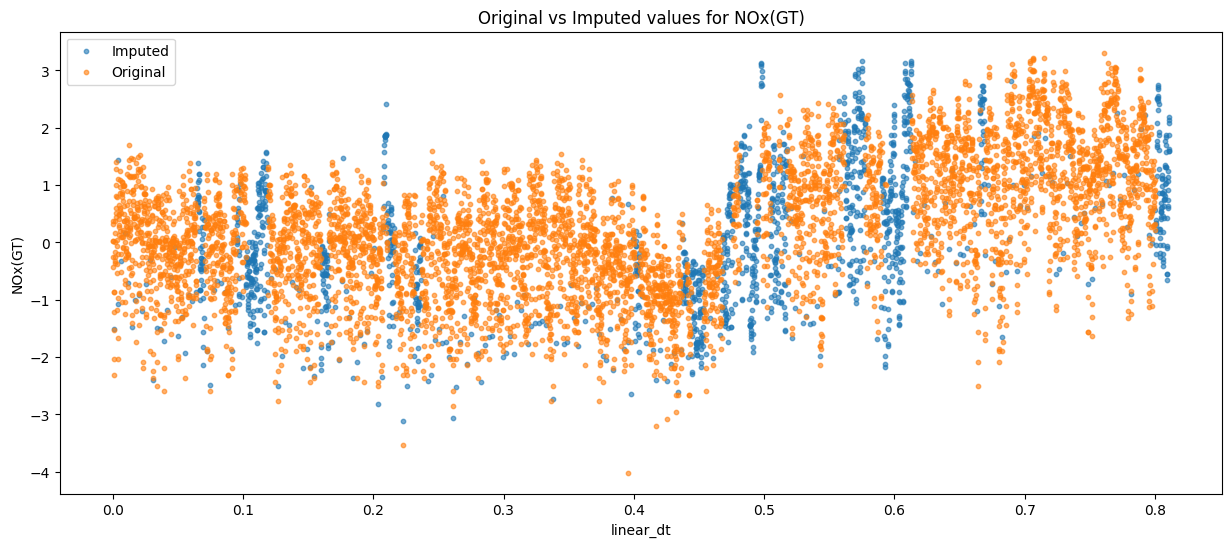

PT08.S3(NOx):
  Original points: 6882
  Imputed points: 228


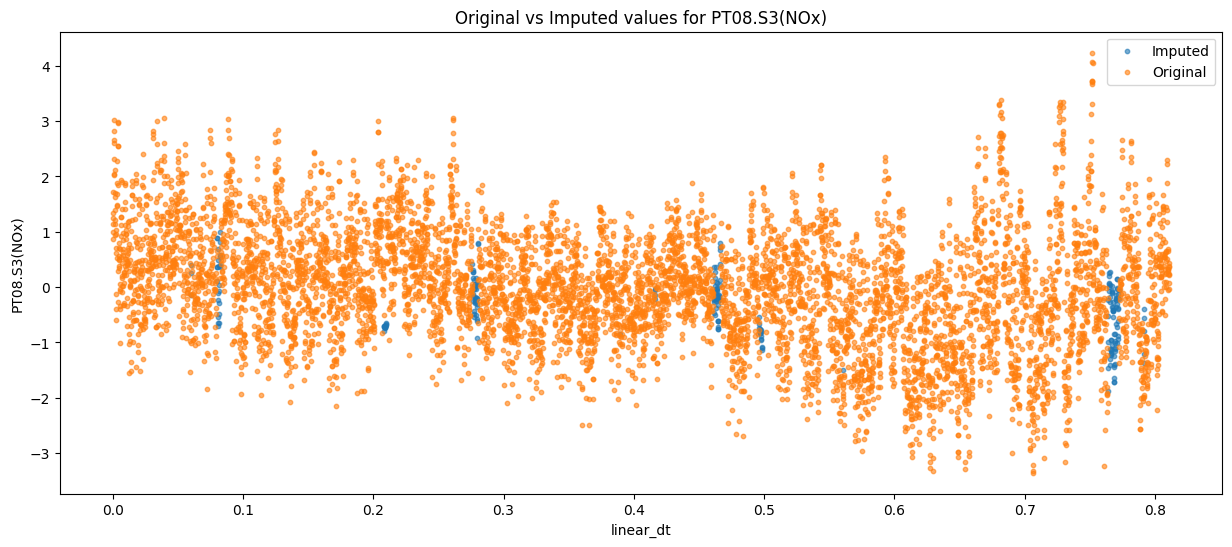

NO2(GT):
  Original points: 5543
  Imputed points: 1567


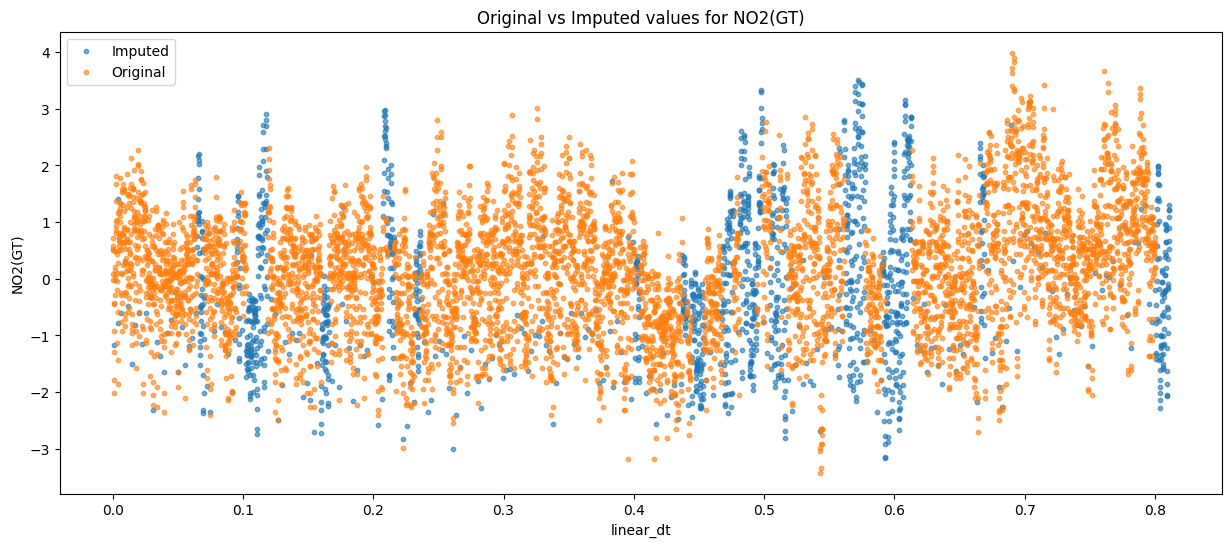

PT08.S4(NO2):
  Original points: 6882
  Imputed points: 228


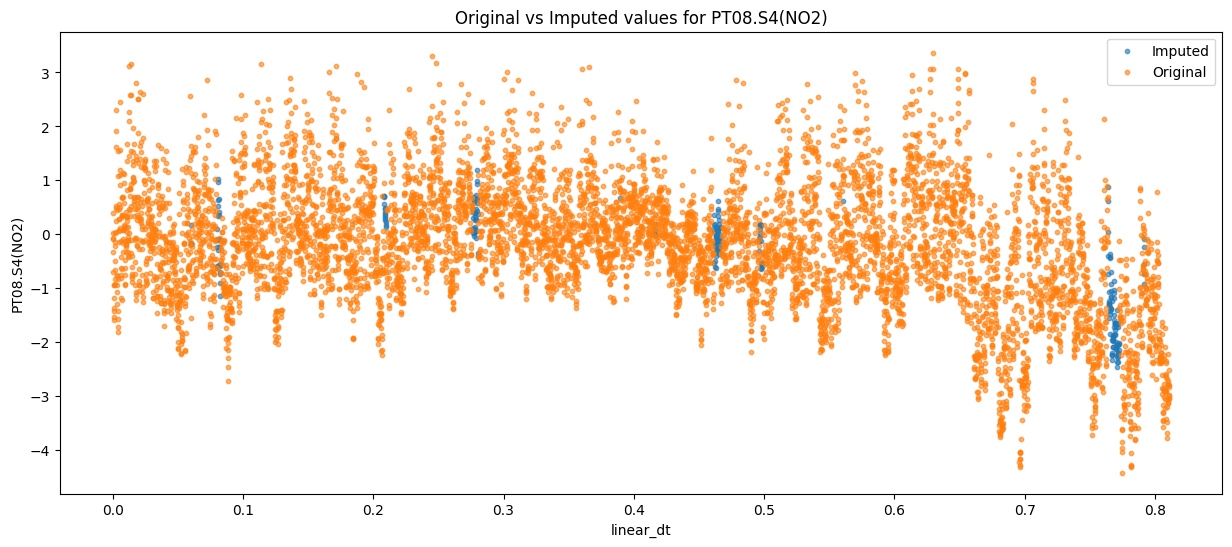

PT08.S5(O3):
  Original points: 6882
  Imputed points: 228


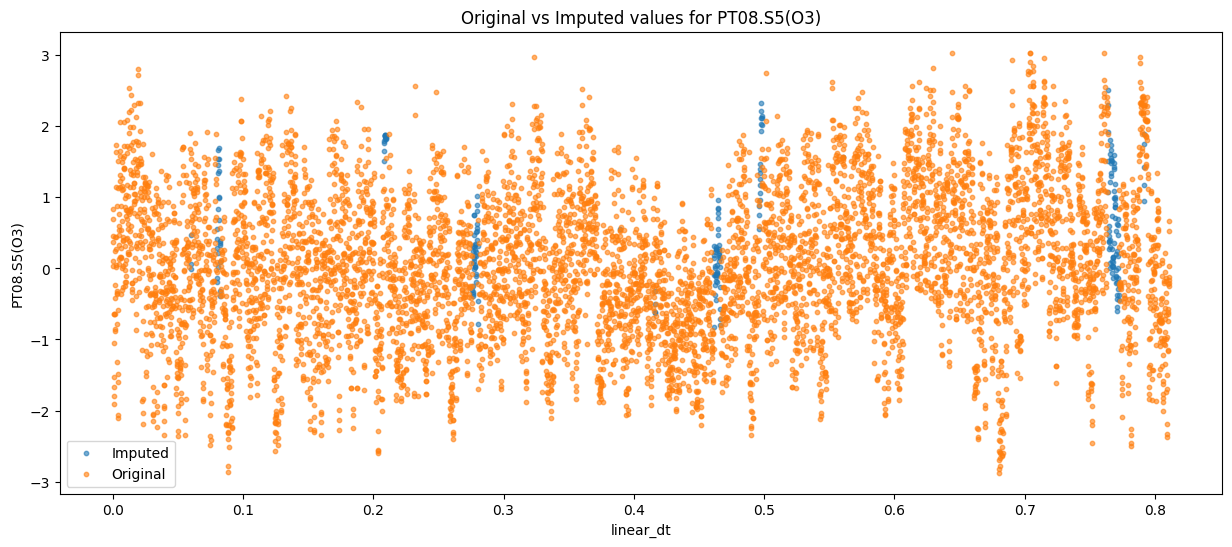

T:
  Original points: 6882
  Imputed points: 228


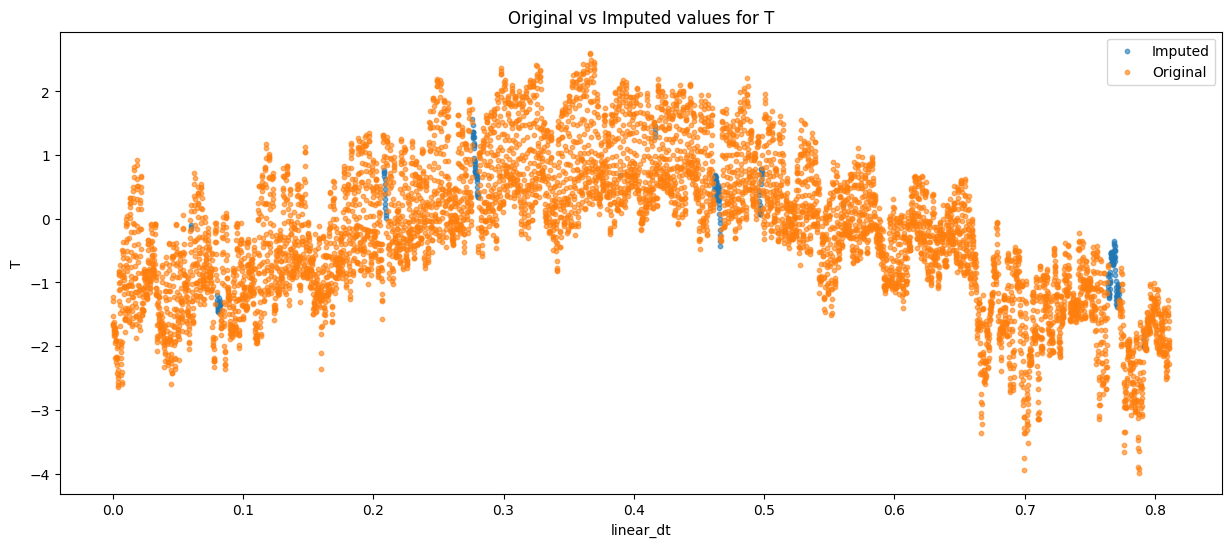

RH:
  Original points: 6882
  Imputed points: 228


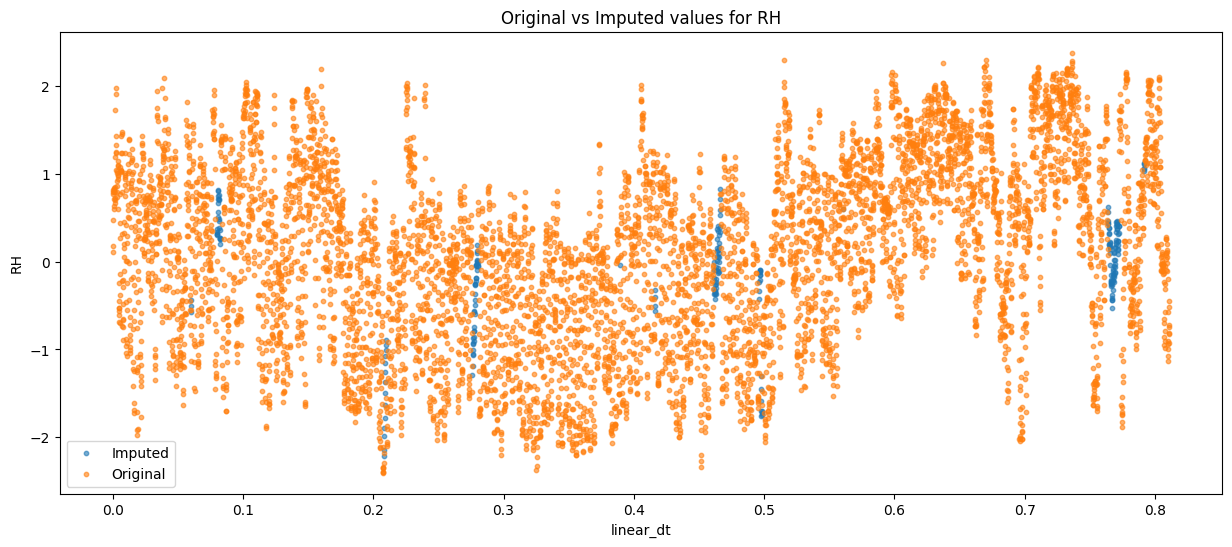

AH:
  Original points: 6882
  Imputed points: 228


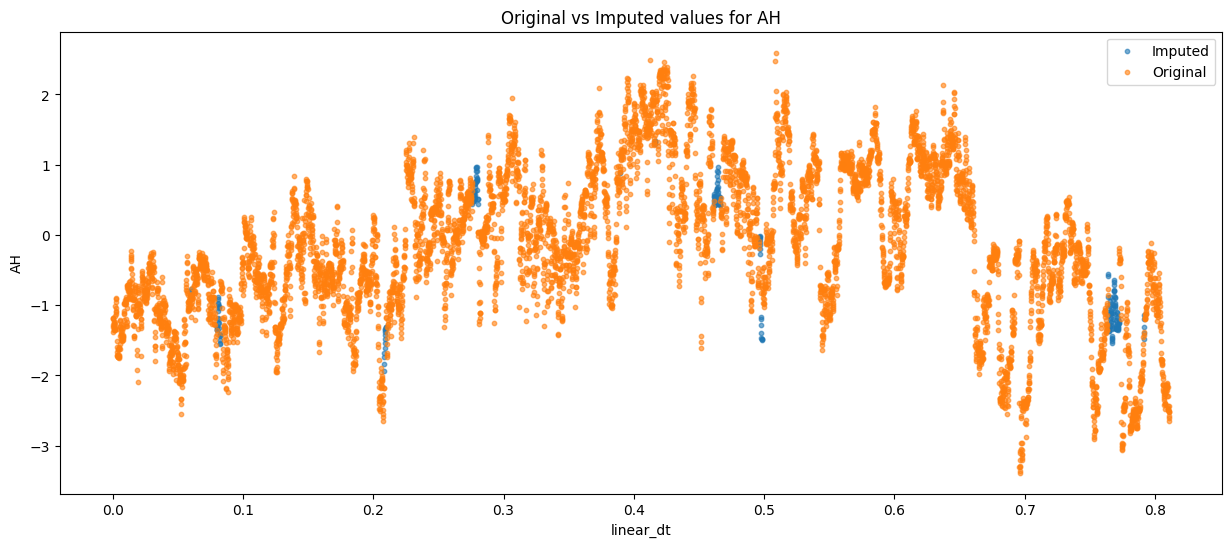

In [31]:
for var in raw_variables:
    plot_original_vs_imputed(
        normalised_data.slice(0, len(normalised_training_and_validation)),
        reimputed_data.slice(0, len(normalised_training_and_validation)),
        var
    )

# Test set!

In [28]:
def denormalise_data(imputed_df: pl.DataFrame, transformers: list[PowerTransformer], variable_names: list[str]) -> pl.DataFrame:
    transformer_map = {var: trans for var, trans in zip(variable_names, transformers)}
    denormalised_cols = []
    
    # Keep non-transformed columns from the input dataframe
    for col_name in imputed_df.columns:
        if col_name not in transformer_map:
            denormalised_cols.append(pl.col(col_name))
            
    # Apply inverse transform for each variable that has a transformer
    for var in variable_names:
        if var in imputed_df.columns:
            transformer = transformer_map[var]
            norm_values = imputed_df.select(pl.col(var)).to_numpy()
            denorm_values = transformer.inverse_transform(norm_values)
            denormalised_cols.append(pl.Series(name=var, values=denorm_values.flatten()))
            
    return imputed_df.select(denormalised_cols)

full_imputation_denormalised = denormalise_data(
    imputed_df=reimputed_data, 
    transformers=transformers, 
    variable_names=raw_variables
)
full_imputation_denormalised.write_ipc("Model A1 denormalised.parquet")

/home/mod/Documents/UNSW/2025 Term 3/COMP9417 Machine Learning/Group assignment final code/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/home/mod/Documents/UNSW/2025 Term 3/COMP9417 Machine Learning/Group assignment final code/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/home/mod/Documents/UNSW/2025 Term 3/COMP9417 Machine Learning/Group assignment final code/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/home/mod/Documents/UNSW/2025 Term 3/COMP9417 Machine Learning/Group assignment final code/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWa

In [ ]:
def evaluate_imputation_loo_cv(
        data: pl.DataFrame,
        variables: list[str],
        impute_function,
        sample_size: int = None,
        test_set_size: int = None
    ) -> dict:
    if test_set_size is None:
        test_set_size = 0  # If not specified, no prioritization
    
    random.seed(42)  # Fixed seed for consistent results
    
    # Convert to numpy for faster operations
    data_np = data.select(variables).to_numpy()
    var_to_idx = {var: idx for idx, var in enumerate(variables)}
    
    errors = {var: [] for var in variables}
    
    for var in variables:
        j = var_to_idx[var]
        # Get all known rows
        all_known = [i for i in range(len(data_np)) if not np.isnan(data_np[i, j])]
        
        # Split into test and non-test
        test_start = len(data_np) - test_set_size
        test_known = [i for i in all_known if i >= test_start]
        non_test_known = [i for i in all_known if i < test_start]
        
        # Determine how many to sample from each
        if sample_size is None:
            sampled_rows = all_known
        else:
            num_from_test = min(len(test_known), sample_size)
            num_from_non_test = max(0, sample_size - num_from_test)
            sampled_rows = random.sample(test_known, num_from_test) + random.sample(non_test_known, min(num_from_non_test, len(non_test_known)))
        
        if not sampled_rows:
            continue  # No known values to evaluate
        
        # Store original values
        originals = data_np[sampled_rows, j].copy()
        
        # Hide the values (set to NaN)
        data_np[sampled_rows, j] = np.nan
        
        # Run imputation on the full data
        imputed_np = impute_function(data_np)
        
        # Compute errors for the sampled positions
        for idx, row in enumerate(sampled_rows):
            imputed_val = imputed_np[row, j]
            if not np.isnan(imputed_val):
                error = (imputed_val - originals[idx]) ** 2
                errors[var].append(error)
        
        # Restore original values
        data_np[sampled_rows, j] = originals
    
    # Compute MSE for each variable
    mse_dict = {}
    for var in variables:
        if errors[var]:
            mse_dict[var] = np.mean(errors[var])
        else:
            mse_dict[var] = None
    
    return mse_dict


def impute_with_model(data_np):
    reimputed_data = data_np.copy()
    model2.double()
    model2.eval()
    starting_index = 4  # for lags [0,1,2,3]
    for i in range(starting_index, len(reimputed_data)):
        model2.predict(reimputed_data, i + 1, mutate=True)
    return reimputed_data


loo_mse = evaluate_imputation_loo_cv(
    normalised_data,
    raw_variables,
    impute_with_model,
    sample_size=50,
    test_set_size=len(normalised_test)
)
print("\nLeave-One-Out CV RMSE Results:")
for var, mse in loo_mse.items():
    if mse is not None:
        print(f"{var}: {'\t' * (var in ['T', 'RH', 'AH'])}\t{math.sqrt(mse):.6f}")
    else:
        print(f"{var}: {'\t' * (var in ['T', 'RH', 'AH'])}\tN/A")


Leave-One-Out CV RMSE Results:
CO(GT): 	0.496085
PT08.S1(CO): 	0.329686
NMHC(GT): 	0.291956
C6H6(GT): 	0.276326
PT08.S2(NMHC): 	0.346460
NOx(GT): 	0.564419
PT08.S3(NOx): 	0.314051
NO2(GT): 	0.403751
PT08.S4(NO2): 	0.413936
PT08.S5(O3): 	0.344753
T: 		0.359721
RH: 		0.586839
AH: 		0.341633
